In [2]:
from datetime import datetime, timezone, timedelta
import time
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from collections import OrderedDict
from linearmodels.panel import BetweenOLS, FirstDifferenceOLS, PanelOLS, PooledOLS, RandomEffects, compare
import statsmodels.api as sm

In [3]:
# Default settings
pd.options.display.max_columns = None
%matplotlib inline
sns.set(style="darkgrid")
random_seed = 42

In [4]:
df_target = pd.read_csv('data/output_objects_borough_cluster_year.csv')
print(df_target.head())
df_target.shape

    REGION OBJECT_CLUSTER  YEAR      AVG_DAY
0  Abcoude      HB_Medium  2010   -12.277174
1  Abcoude      HB_Medium  2011 -1156.000000
2  Abcoude      HB_Medium  2015  1198.987730
3  Abcoude       HB_Small  2010  5960.581105
4  Abcoude       HB_Small  2011  6650.036107


(808, 4)

In [5]:
# Checking regions in Dataset
df_target.REGION.unique()

array(['Abcoude', 'Amstelveen', 'Centrum', 'Diemen', 'Heemstede',
       'Muiden', 'Nieuw-West', 'Noord', 'Oost', 'Ouder-Amstel',
       'Undefined', 'West', 'Westpoort', 'Zuid', 'Zuidoost'], dtype=object)

In [6]:
# Checking clusters in Dataset
df_target.OBJECT_CLUSTER.unique()

array(['HB_Medium', 'HB_Small', 'ZB_Medium', 'ZB_Small', 'HB_Large',
       'ZB_Large', 'ZB_Mega', 'HB_Mega'], dtype=object)

In [7]:
# Removing Undefined, Abcoude, and Muiden from the dataset because they are not in scope
df_target = df_target.loc[~df_target.REGION.isin(['Undefined', 'Abcoude', 'Muiden'])]
df_target

,REGION,OBJECT_CLUSTER,YEAR,AVG_DAY
33,Amstelveen,HB_Large,2010,9.711431e+05
34,Amstelveen,HB_Large,2011,5.485785e+05
35,Amstelveen,HB_Large,2012,5.430256e+05
36,Amstelveen,HB_Large,2013,1.169675e+06
37,Amstelveen,HB_Large,2014,9.206660e+05
...,...,...,...,...
803,Zuidoost,ZB_Small,2015,2.390724e+05
804,Zuidoost,ZB_Small,2016,2.412996e+05
805,Zuidoost,ZB_Small,2017,2.383869e+05
806,Zuidoost,ZB_Small,2018,2.485874e+05


In [8]:
# Adding distinction Households and businesses
df_target['OBJ_TYPE'] = df_target.OBJECT_CLUSTER.str[:2]
df_target

,REGION,OBJECT_CLUSTER,YEAR,AVG_DAY,OBJ_TYPE
33,Amstelveen,HB_Large,2010,9.711431e+05,HB
34,Amstelveen,HB_Large,2011,5.485785e+05,HB
35,Amstelveen,HB_Large,2012,5.430256e+05,HB
36,Amstelveen,HB_Large,2013,1.169675e+06,HB
37,Amstelveen,HB_Large,2014,9.206660e+05,HB
...,...,...,...,...,...
803,Zuidoost,ZB_Small,2015,2.390724e+05,ZB
804,Zuidoost,ZB_Small,2016,2.412996e+05,ZB
805,Zuidoost,ZB_Small,2017,2.383869e+05,ZB
806,Zuidoost,ZB_Small,2018,2.485874e+05,ZB


In [9]:
# Showing total consumption per segment per year
df_clusters = pd.pivot_table(df_target, index='OBJECT_CLUSTER', columns='YEAR', values='AVG_DAY', aggfunc=np.sum)
df_clusters

YEAR,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
OBJECT_CLUSTER,,,,,,,,,,
HB_Large,1.245527e+06,6.772757e+05,6.539058e+05,1.227155e+06,1.048685e+06,4.196684e+05,1.627200e+05,3.730103e+05,4.642298e+05,2.588850e+05
HB_Medium,4.822970e+06,4.225227e+06,4.158474e+06,4.769568e+06,4.613109e+06,3.897769e+06,3.437077e+06,3.739457e+06,4.608229e+06,1.815709e+06
HB_Mega,NaN,-1.239605e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HB_Small,1.521535e+07,2.445093e+07,2.538478e+07,2.446329e+07,2.521586e+07,2.772667e+07,2.907671e+07,2.892355e+07,2.880822e+07,1.468813e+07
ZB_Large,5.125274e+06,5.680012e+06,5.930347e+06,5.760120e+06,6.270713e+06,6.532994e+06,5.866960e+06,6.465899e+06,6.454721e+06,3.901874e+06
ZB_Medium,8.260146e+06,8.288112e+06,8.381299e+06,8.418720e+06,8.521256e+06,8.721767e+06,8.978204e+06,9.135537e+06,9.827991e+06,5.139670e+06
ZB_Mega,NaN,2.779865e+05,NaN,2.438123e+05,2.019424e+05,3.885641e+05,3.564800e+05,2.274708e+05,1.164754e+05,2.424117e+05
ZB_Small,3.338875e+06,3.333631e+06,3.689951e+06,3.573860e+06,3.803241e+06,3.856744e+06,4.035675e+06,3.906533e+06,3.892891e+06,2.045344e+06


In [10]:
# Showing total consumption per object type per year
df_types = pd.pivot_table(df_target, index='OBJ_TYPE', columns='YEAR', values='AVG_DAY', aggfunc=np.sum)
df_types

YEAR,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
OBJ_TYPE,,,,,,,,,,
HB,2.128384e+07,2.922947e+07,3.019716e+07,3.046001e+07,3.087765e+07,3.204411e+07,3.267650e+07,3.303602e+07,3.388068e+07,1.676273e+07
ZB,1.672430e+07,1.757974e+07,1.800160e+07,1.799651e+07,1.879715e+07,1.950007e+07,1.923732e+07,1.973544e+07,2.029208e+07,1.132930e+07


In [11]:
# Creating series with full consumption from old excel file
total_households = pd.Series(data={2013: 47e6, 2014: 48e6, 2015: 48.1e6, 2016: 49.2e6, 2017: 48.7e6, 2018: 49.95e6,\
    2019: 50.3e6}, name='Total_HH')
total_businesses = pd.Series(data={2013: 18.7e6, 2014: 19.5e6, 2015: 20e6, 2016: 20.2e6, 2017: 20.9e6, 2018: 21.2e6,\
    2019: 21.3e6}, name='Total_BS')
# Creating series with predictions from old excel file
total_households_forecast = pd.Series(data={2017: 49.89e6, 2018: 50.28e6, 2019: 50.19e6, 2020: 51.05e6,\
    2021: 51.44e6, 2022: 51.95e6, 2023: 52.47e6, 2024: 53.12e6, 2025: 53.44e6, 2026: 53.85e6},\
    name='Forecast_HH')
total_businesses_forecast = pd.Series(data={2017: 20.5e6, 2018: 20.6e6, 2019: 21.05e6, 2020: 21.5e6,\
    2021: 21.46e6, 2022: 21.56e6, 2023: 21.67e6, 2024: 21.78e6, 2025: 21.89e6, 2026: 22.0e6},\
    name='Forecast_BS')

In [12]:
df_households = df_types.loc['HB'].to_frame().join(total_households)
df_households['%'] = df_households.HB / df_households.Total_HH
df_households

,HB,Total_HH,%
YEAR,,,
2010,2.128384e+07,NaN,NaN
2011,2.922947e+07,NaN,NaN
2012,3.019716e+07,NaN,NaN
2013,3.046001e+07,47000000.0,0.648085
2014,3.087765e+07,48000000.0,0.643284
2015,3.204411e+07,48100000.0,0.666198
2016,3.267650e+07,49200000.0,0.664157
2017,3.303602e+07,48700000.0,0.678358
2018,3.388068e+07,49950000.0,0.678292


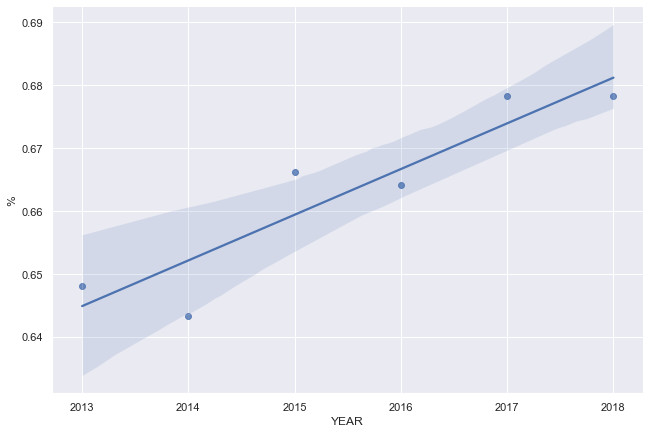

In [13]:
# Plotting % of households that are measured (Bemeten)
g = sns.lmplot(x='YEAR', y='%', data=df_households.loc[2013:2018].reset_index(),\
    palette='plasma', height=6, aspect=1.5)

plt.show()

In [14]:
# Fitting LR through datapoints to get coefficient
X = np.array(df_households.loc[2013:2018].index).reshape(-1, 1)
y = np.array(df_households.loc[2013:2018].reset_index()['%'])
mod = LinearRegression().fit(X, y)
mod.coef_[0]

0.00726317874293558

In [15]:
# Extrapolating trendline
extrap = [y[-1] + mod.coef_[0] * i for i in range(1, 9)]
extrap

[0.6855550670832921,
 0.6928182458262276,
 0.7000814245691632,
 0.7073446033120988,
 0.7146077820550344,
 0.72187096079797,
 0.7291341395409056,
 0.7363973182838411]

In [16]:
df_households = df_households.loc[2013:2018].reset_index().append(pd.DataFrame(zip(range(2019, 2027), extrap))\
    .rename(columns={0: 'YEAR', 1: '%'}))
df_households

,YEAR,HB,Total_HH,%
0,2013,3.046001e+07,47000000.0,0.648085
1,2014,3.087765e+07,48000000.0,0.643284
2,2015,3.204411e+07,48100000.0,0.666198
3,2016,3.267650e+07,49200000.0,0.664157
4,2017,3.303602e+07,48700000.0,0.678358
5,2018,3.388068e+07,49950000.0,0.678292
0,2019,NaN,NaN,0.685555
1,2020,NaN,NaN,0.692818
2,2021,NaN,NaN,0.700081
3,2022,NaN,NaN,0.707345


In [17]:
# Now getting business consumption
df_businesses = df_types.loc['ZB'].to_frame().join(total_businesses)
df_businesses['%'] = df_businesses.ZB / df_businesses.Total_BS
df_businesses

,ZB,Total_BS,%
YEAR,,,
2010,1.672430e+07,NaN,NaN
2011,1.757974e+07,NaN,NaN
2012,1.800160e+07,NaN,NaN
2013,1.799651e+07,18700000.0,0.962380
2014,1.879715e+07,19500000.0,0.963957
2015,1.950007e+07,20000000.0,0.975003
2016,1.923732e+07,20200000.0,0.952343
2017,1.973544e+07,20900000.0,0.944279
2018,2.029208e+07,21200000.0,0.957173


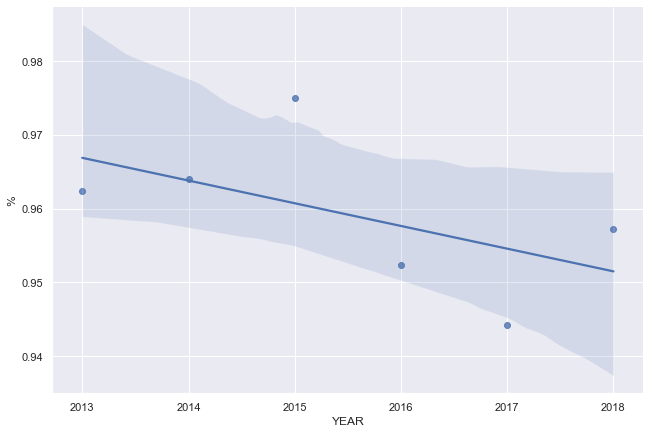

In [18]:
# Plotting % of business that are measured (Bemeten)
g = sns.lmplot(x='YEAR', y='%', data=df_businesses.loc[2013:2018].reset_index(),\
    palette='plasma', height=6, aspect=1.5)

plt.show()

In [19]:
# Fitting LR through datapoints to get coefficient
X = np.array(df_businesses.loc[2013:2018].index).reshape(-1, 1)
y = np.array(df_businesses.loc[2013:2018].reset_index()['%'])
mod = LinearRegression().fit(X, y)
mod.coef_[0]

-0.003077900225942534

In [20]:
# Extrapolating trendline
extrap = [y[-1] + mod.coef_[0] * i for i in range(1, 9)]
extrap

[0.954095589537559,
 0.9510176893116166,
 0.947939789085674,
 0.9448618888597314,
 0.9417839886337889,
 0.9387060884078464,
 0.9356281881819039,
 0.9325502879559613]

In [21]:
df_businesses = df_businesses.loc[2013:2018].reset_index().append(pd.DataFrame(zip(range(2019, 2027), extrap))\
    .rename(columns={0: 'YEAR', 1: '%'}))
df_businesses

,YEAR,ZB,Total_BS,%
0,2013,1.799651e+07,18700000.0,0.962380
1,2014,1.879715e+07,19500000.0,0.963957
2,2015,1.950007e+07,20000000.0,0.975003
3,2016,1.923732e+07,20200000.0,0.952343
4,2017,1.973544e+07,20900000.0,0.944279
5,2018,2.029208e+07,21200000.0,0.957173
0,2019,NaN,NaN,0.954096
1,2020,NaN,NaN,0.951018
2,2021,NaN,NaN,0.947940
3,2022,NaN,NaN,0.944862


In [22]:
# Splitting into Households and Business subsets
df_target_HB = df_target.loc[df_target.OBJECT_CLUSTER.str[:2] == 'HB'].groupby(['REGION', 'YEAR']).sum().reset_index()
df_target_ZB = df_target.loc[df_target.OBJECT_CLUSTER.str[:2] == 'ZB'].groupby(['REGION', 'YEAR']).sum().reset_index()
df_target_HB

,REGION,YEAR,AVG_DAY
0,Amstelveen,2010,3.046941e+06
1,Amstelveen,2011,3.368218e+06
2,Amstelveen,2012,3.495221e+06
3,Amstelveen,2013,3.393728e+06
4,Amstelveen,2014,3.383896e+06
...,...,...,...
115,Zuidoost,2015,4.040973e+06
116,Zuidoost,2016,4.132988e+06
117,Zuidoost,2017,4.067511e+06
118,Zuidoost,2018,4.172240e+06


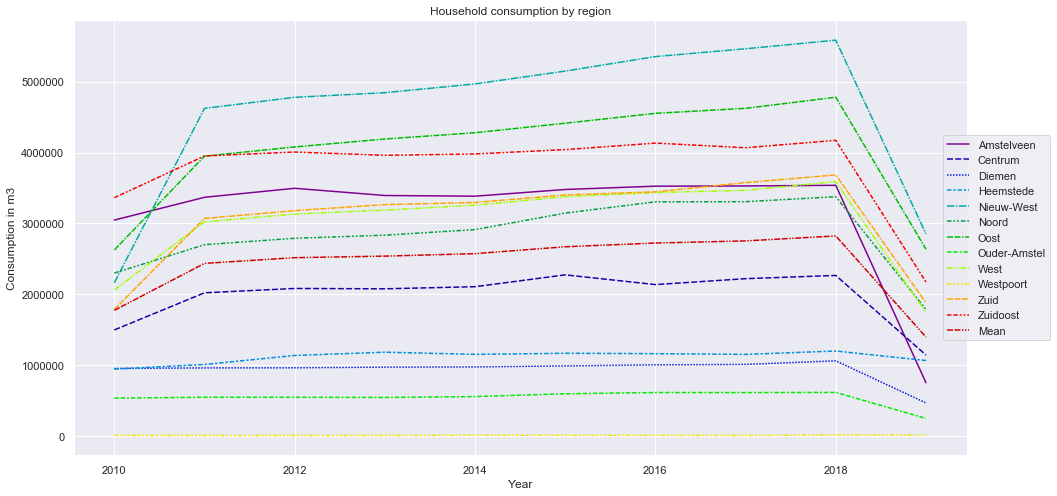

In [23]:
# Plot yearly trend for households
df = pd.pivot_table(df_target_HB, index='YEAR', columns='REGION', values='AVG_DAY', aggfunc=np.sum)
df['Mean'] = df.mean(axis=1)

fig, ax = plt.subplots(figsize=(16, 8))

sns.lineplot(data=df, ax=ax, palette='nipy_spectral')
ax.set(xlabel='Year', ylabel='Consumption in m3', title='Household consumption by region')

# Put a legend to the right side
plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.5), ncol=1)

plt.show()

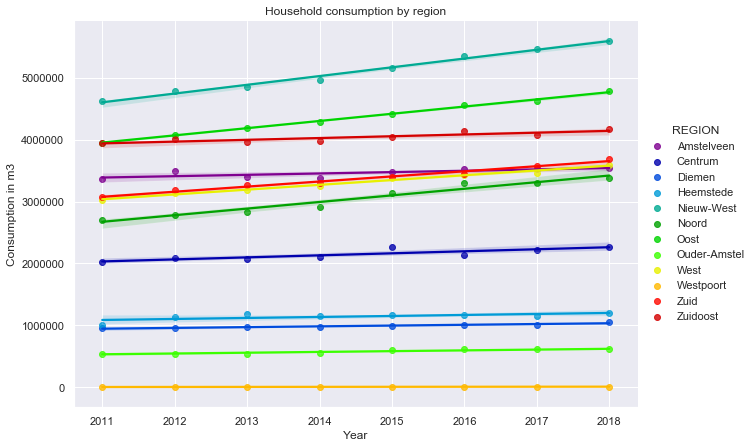

In [24]:
# Yearly lm plot for households
g = sns.lmplot(x='YEAR', y='AVG_DAY', hue='REGION',\
    data=df_target_HB.loc[df_target_HB.YEAR.between(2011, 2018)],\
        palette='nipy_spectral', height=6, aspect=1.5)
g.set(xlabel='Year', ylabel='Consumption in m3', title='Household consumption by region')

plt.show()

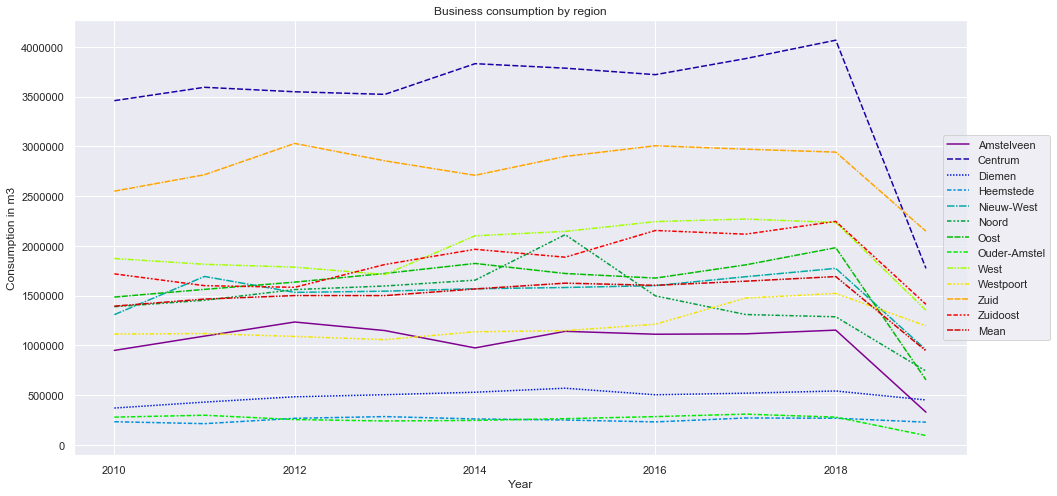

In [25]:
# Plot yearly trend for businesses
df2 = pd.pivot_table(df_target_ZB, index='YEAR', columns='REGION', values='AVG_DAY', aggfunc=np.sum)
df2['Mean'] = df2.mean(axis=1)

fig, ax = plt.subplots(figsize=(16, 8))

sns.lineplot(data=df2, ax=ax, palette='nipy_spectral')
ax.set(xlabel='Year', ylabel='Consumption in m3', title='Business consumption by region')

# Put a legend to the right side
plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.5), ncol=1)

plt.show()

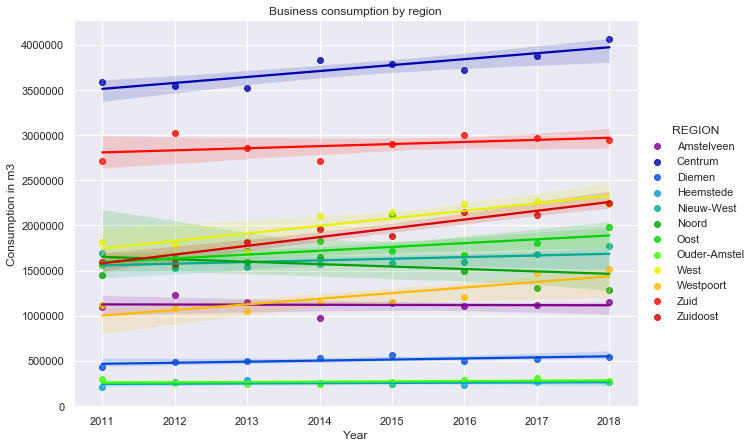

In [26]:
# Yearly lm plot for businesses
g = sns.lmplot(x='YEAR', y='AVG_DAY', hue='REGION',\
    data=df_target_ZB.loc[df_target_ZB.YEAR.between(2011, 2018)],\
        palette='nipy_spectral', height=6, aspect=1.5)
g.set(xlabel='Year', ylabel='Consumption in m3', title='Business consumption by region')

plt.show()

In [27]:
# Loading input dataset
df_input = pd.read_csv('data/input_features_extrap.csv', sep=',', decimal='.')
# Removing Muiden from data, because of change of municipality in 2015
df_input = df_input.loc[df_input.REGION != 'Muiden']
# Including full dataset, up to 2026
df_input = df_input.loc[df_input.YEAR.between(2011, 2026)]
# Creating time dummies
#df_input['year'] = pd.Categorical(df_input.YEAR)
# Setting multi-index
df_input = df_input.set_index(['REGION', 'YEAR'])
df_input

POPULATION  POPULATION 0 TO 15 Y/O  \
REGION     YEAR                                         
Amstelveen 2011  81796.000000            13594.000000   
           2012  83363.000000            13927.000000   
           2013  84379.000000            14182.000000   
           2014  85015.000000            14359.000000   
           2015  87162.000000            14857.000000   
...                       ...                     ...   
Zuidoost   2022  91400.300503            14290.343934   
           2023  92278.270199            14170.174535   
           2024  93156.239896            14050.005137   
           2025  94034.209592            13929.835738   
           2026  94912.179289            13809.666339   

                 POPULATION 15 TO 25 Y/O  POPULATION 25 TO 45 Y/O  \
REGION     YEAR                                                     
Amstelveen 2011              9688.000000             21091.000000   
           2012              9850.000000             21508.000000   
           2013             10070.000000             21666.000000   
           2014             10167.000000             21619.000000   
           2015             10560.000000             22158.000000   
...                                  ...                      ...   
Zuidoost   2022             14333.505379             26522.011857   
           2023             14530.559932             26790.353663   
           2024             14727.614485             27058.695469   
           2025             14924.669039             27327.037276   
           2026             15121.723592             27595.379082   

                 POPULATION 45 TO 65 Y/O  POPULATION 65 Y/O AND UP  \
REGION     YEAR                                                      
Amstelveen 2011             22362.000000              15061.000000   
           2012             22440.000000              15638.000000   
           2013             22472.000000              15989.000000   
           2014             22678.000000              16192.000000   
           2015             22993.000000              16594.000000   
...                                  ...                       ...   
Zuidoost   2022             24220.196559              11947.622670   
           2023             24314.952955              12356.458436   
           2024             24409.709350              12765.294202   
           2025             24504.465746              13174.129968   
           2026             24599.222141              13582.965734   

                 TOTAL HOUSEHOLDS  SINGLE-PERSON HOUSEHOLDS  \
REGION     YEAR                                               
Amstelveen 2011      39669.000000              17441.000000   
           2012      40295.000000              17602.000000   
           2013      40865.000000              17999.000000   
           2014      40942.000000              17779.000000   
           2015      42154.000000              18468.000000   
...                           ...                       ...   
Zuidoost   2022      49372.606113              27895.778667   
           2023      50112.545512              28567.593819   
           2024      50852.484911              29239.408970   
           2025      51592.424311              29911.224121   
           2026      52332.363710              30583.039273   

                 HOUSEHOLDS W/O CHILDREN  HOUSEHOLDS /W CHILDREN  \
REGION     YEAR                                                    
Amstelveen 2011              9879.000000            12349.000000   
           2012             10070.000000            12623.000000   
           2013              9990.000000            12876.000000   
           2014             10025.000000            13138.000000   
           2015             10187.000000            13499.000000   
...                                  ...                     ...   
Zuidoost   2022              7388.977177            14172.486970   
           2023              7454.60

In [28]:
# Splitting into train and test sets
train = df_input.loc(axis=0)[(slice(None), slice(2011,2017))]
test = df_input.loc(axis=0)[(slice(None), 2018)]
fcst = df_input.loc(axis=0)[(slice(None), slice(2011,2018))]
extrap = df_input.loc(axis=0)[(slice(None), slice(2019, 2026))]
print(train.shape, test.shape, extrap.shape)

(84, 29) (12, 29) (96, 29)


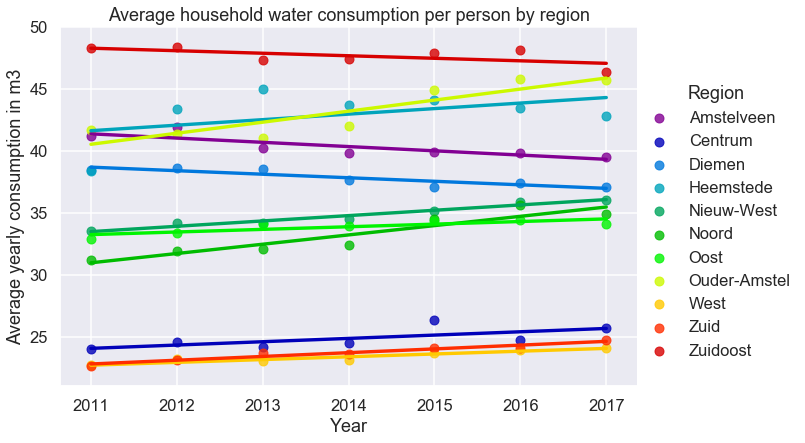

In [29]:
df_consumption = train.reset_index().merge(df_target_HB, how='left', on=['YEAR', 'REGION'])\
    [['REGION', 'YEAR', 'POPULATION', 'AVG_DAY']]
# add calculated column with consumption per person
df_consumption['CONSUMPTION_PP'] = df_consumption['AVG_DAY'] / df_consumption['POPULATION']

sns.set_context('talk', rc={'font_scale':1.2})#, 'axes.titlesize':18, 'axes.labelsize':18})

# Plotting consumption per person for each region
g = sns.lmplot(x='YEAR', y='CONSUMPTION_PP', hue='REGION',\
    data=df_consumption.loc[df_consumption.REGION != 'Westpoort'],\
        palette='nipy_spectral', height=6, aspect=1.50, ci=None)

g.set(xlabel='Year', ylabel='Average yearly consumption in m3',\
    title='Average household water consumption per person by region')
g.legend.set_title('Region')

plt.show()

In [30]:
# normalizing numerical features
scaler = StandardScaler()
train[train.columns] = scaler.fit_transform(train)
# creating time and entity dummies for training set
year = pd.Categorical(train.index.get_level_values('YEAR'))
region = pd.Categorical(train.index.get_level_values('REGION'))
print(year, region)
train['year'] = year
train['region'] = region
train

[2011, 2012, 2013, 2014, 2015, ..., 2013, 2014, 2015, 2016, 2017]
Length: 84
Categories (7, int64): [2011, 2012, 2013, 2014, 2015, 2016, 2017] ['Amstelveen', 'Amstelveen', 'Amstelveen', 'Amstelveen', 'Amstelveen', ..., 'Zuidoost', 'Zuidoost', 'Zuidoost', 'Zuidoost', 'Zuidoost']
Length: 84
Categories (12, object): ['Amstelveen', 'Centrum', 'Diemen', 'Heemstede', ..., 'West', 'Westpoort', 'Zuid', 'Zuidoost']


POPULATION  POPULATION 0 TO 15 Y/O  POPULATION 15 TO 25 Y/O  \
REGION     YEAR                                                                
Amstelveen 2011    0.031030                0.114747                -0.090515   
           2012    0.062193                0.155342                -0.066096   
           2013    0.082398                0.186428                -0.032933   
           2014    0.095047                0.208005                -0.018312   
           2015    0.137744                0.268714                 0.040929   
...                     ...                     ...                      ...   
Zuidoost   2013    0.069193                0.294522                 0.341992   
           2014    0.075458                0.301434                 0.349115   
           2015    0.083910                0.318452                 0.332609   
           2016    0.111454                0.295290                 0.440387   
           2017    0.151128                0.289194                 0.529323   

                 POPULATION 25 TO 45 Y/O  POPULATION 45 TO 65 Y/O  \
REGION     YEAR                                                     
Amstelveen 2011                -0.284896                 0.191878   
           2012                -0.263908                 0.198619   
           2013                -0.255956                 0.201384   
           2014                -0.258321                 0.219185   
           2015                -0.231193                 0.246404   
...                                  ...                      ...   
Zuidoost   2013                -0.124523                 0.285048   
           2014                -0.119925                 0.292669   
           2015                -0.129674                 0.297992   
           2016                -0.118601                 0.317435   
           2017                -0.075065                 0.334717   

                 POPULATION 65 Y/O AND UP  TOTAL HOUSEHOLDS  \
REGION     YEAR                                               
Amstelveen 2011                  0.767020         -0.115194   
           2012                  0.861275         -0.093152   
           2013                  0.918613         -0.073081   
           2014                  0.951774         -0.070370   
           2015                  1.017442         -0.027693   
...                                   ...               ...   
Zuidoost   2013                 -0.325738          0.001567   
           2014                 -0.320592         -0.003714   
           2015                 -0.232871          0.017765   
           2016                 -0.161812          0.064596   
           2017                 -0.097287          0.125512   

                 SINGLE-PERSON HOUSEHOLDS  HOUSEHOLDS W/O CHILDREN  \
REGION     YEAR                                                      
Amstelveen 2011                 -0.321943                 0.151545   
           2012                 -0.312467                 0.184703   
           2013                 -0.289101                 0.170815   
           2014                 -0.302050                 0.176891   
           2015                 -0.261498                 0.205015   
...                                   ...                      ...   
Zuidoost   2013                 -0.058190                -0.369504   
           2014                 -0.062692                -0.373671   
           2015                 -0.024486                -0.364748   
           2016                  0.054675                -0.356936   
           2017                  0.141192                -0.333499   

                 HOUSEHOLDS /W CHILDREN  AIRBNB_REVIEWS  UNEMPLOYMENT_WW  \
REGION     YEAR                                                            
Amstelveen 2011                0.187223       -0.477539        -0.537758   
           2012                0.226947       -0.477539        -0.291854   
           2013                0.263626    

In [31]:
train.describe()

,POPULATION,POPULATION 0 TO 15 Y/O,POPULATION 15 TO 25 Y/O,POPULATION 25 TO 45 Y/O,POPULATION 45 TO 65 Y/O,POPULATION 65 Y/O AND UP,TOTAL HOUSEHOLDS,SINGLE-PERSON HOUSEHOLDS,HOUSEHOLDS W/O CHILDREN,HOUSEHOLDS /W CHILDREN,AIRBNB_REVIEWS,UNEMPLOYMENT_WW,NUMBER_OF_JOBS,GUESTS_HOTELS,OVERNIGHT_STAYS_HOTELS,BUILT_before_1945,BUILT_1945_to_1965,BUILT_1965_to_1975,BUILT_1975_to_1985,BUILT_1985_to_1995,BUILT_1995_to_2005,BUILT_2005_to_2015,RENTAL_HOMES,UNINHABITED,LOW_INCOMES,HIGH_INCOME,PLACES_TO_EAT,NATURAL_GAS_M3,ELECTRICITY_KWH
count,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01
mean,6.178920e-17,-2.577303e-16,-8.855350e-17,1.690116e-16,3.006854e-16,-2.114711e-17,1.163091e-16,-2.319573e-16,1.414213e-16,-2.081668e-16,2.973812e-18,3.436405e-17,-7.269317e-17,-5.716327e-17,1.817329e-16,4.361590e-17,6.079793e-17,7.269317e-17,1.374562e-16,1.057355e-17,-1.495166e-17,7.847559e-17,-1.035052e-16,1.890023e-16,-1.519948e-16,-1.506731e-16,-7.930164e-18,-7.004979e-17,2.643388e-18
std,1.006006e+00,1.006006e+00,1.006006e+00,1.006006e+00,1.006006e+00,1.006006e+00,1.006006e+00,1.006006e+00,1.006006e+00,1.006006e+00,1.006006e+00,1.006006e+00,1.006006e+00,1.006006e+00,1.006006e+00,1.006006e+00,1.006006e+00,1.006006e+00,1.006006e+00,1.006006e+00,1.006006e+00,1.006006e+00,1.006006e+00,1.006006e+00,1.006006e+00,1.006006e+00,1.006006e+00,1.006006e+00,1.006006e+00
min,-1.591878e+00,-1.540393e+00,-1.548613e+00,-1.343164e+00,-1.733552e+00,-1.690808e+00,-1.506893e+00,-1.341382e+00,-1.561735e+00,-1.600190e+00,-4.775392e-01,-1.470496e+00,-1.345292e+00,-6.442327e-01,-6.421576e-01,-7.812080e-01,-7.115044e-01,-1.128002e+00,-8.470675e-01,-1.558457e+00,-9.552816e-01,-9.299112e-01,-1.373667e+00,-1.235854e+00,-1.414167e+00,-1.440977e+00,-7.034239e-01,-8.697011e-01,-9.062808e-01
25%,-1.071586e+00,-9.890493e-01,-1.025474e+00,-1.047618e+00,-1.079025e+00,-7.744722e-01,-1.086829e+00,-1.050046e+00,-9.766955e-01,-1.028476e+00,-4.775392e-01,-1.076202e+00,-8.868898e-01,-6.147530e-01,-6.136387e-01,-7.544011e-01,-6.389869e-01,-7.713747e-01,-6.224683e-01,-7.413827e-01,-7.012447e-01,-7.035818e-01,-1.058825e+00,-9.436432e-01,-1.067034e+00,-8.129276e-01,-6.610298e-01,-7.079792e-01,-7.322302e-01
50%,1.181654e-01,2.949058e-01,1.036212e-01,-1.222241e-01,2.888585e-01,1.148323e-01,-1.718656e-05,-1.288079e-01,1.433859e-01,4.041583e-01,-4.701262e-01,1.359334e-01,-1.807379e-01,-4.065281e-01,-4.049459e-01,-5.906615e-01,-4.180316e-01,-2.278335e-01,-1.503191e-01,1.816994e-01,-3.337828e-01,-1.298929e-01,1.946896e-02,-3.445518e-01,8.051531e-02,-1.401331e-01,-5.739110e-01,-6.117219e-01,-6.286349e-01
75%,1.060442e+00,7.089377e-01,8.477815e-01,8.957561e-01,9.046968e-01,6.878748e-01,8.418017e-01,7.857357e-01,8.709332e-01,7.770591e-01,-1.145012e-01,8.195879e-01,8.139400e-01,-2.248943e-02,-1.731188e-02,6.815051e-01,3.347448e-01,5.911458e-01,7.361684e-02,5.851864e-01,-1.379926e-02,5.306067e-02,9.642905e-01,8.943275e-01,1.032094e+00,6.128306e-01,5.476291e-01,1.018738e+00,1.314027e+00
max,1.419727e+00,1.793513e+00,1.815126e+00,1.834005e+00,1.344440e+00,1.807423e+00,1.515310e+00,1.645249e+00,1.678550e+00,1.792256e+00,4.154000e+00,2.034055e+00,1.895869e+00,3.906104e+00,3.983330e+00,2.072900e+00,3.098034e+00,2.615072e+00,3.124345e+00,1.725378e+00,2.284978e+00,2.693943e+00,1.515379e+00,1.922862e+00,1.390201e+00,1.932785e+00,2.896975e+00,2.397477e+00,1.647130e+00


In [32]:
# joining with consumptions per object type
train_HB = train.reset_index().merge(df_target_HB, how='left', on=['YEAR', 'REGION']).set_index(['REGION', 'YEAR'])
train_ZB = train.reset_index().merge(df_target_ZB, how='left', on=['YEAR', 'REGION']).set_index(['REGION', 'YEAR'])
train_HB

POPULATION  POPULATION 0 TO 15 Y/O  POPULATION 15 TO 25 Y/O  \
REGION     YEAR                                                                
Amstelveen 2011    0.031030                0.114747                -0.090515   
           2012    0.062193                0.155342                -0.066096   
           2013    0.082398                0.186428                -0.032933   
           2014    0.095047                0.208005                -0.018312   
           2015    0.137744                0.268714                 0.040929   
...                     ...                     ...                      ...   
Zuidoost   2013    0.069193                0.294522                 0.341992   
           2014    0.075458                0.301434                 0.349115   
           2015    0.083910                0.318452                 0.332609   
           2016    0.111454                0.295290                 0.440387   
           2017    0.151128                0.289194                 0.529323   

                 POPULATION 25 TO 45 Y/O  POPULATION 45 TO 65 Y/O  \
REGION     YEAR                                                     
Amstelveen 2011                -0.284896                 0.191878   
           2012                -0.263908                 0.198619   
           2013                -0.255956                 0.201384   
           2014                -0.258321                 0.219185   
           2015                -0.231193                 0.246404   
...                                  ...                      ...   
Zuidoost   2013                -0.124523                 0.285048   
           2014                -0.119925                 0.292669   
           2015                -0.129674                 0.297992   
           2016                -0.118601                 0.317435   
           2017                -0.075065                 0.334717   

                 POPULATION 65 Y/O AND UP  TOTAL HOUSEHOLDS  \
REGION     YEAR                                               
Amstelveen 2011                  0.767020         -0.115194   
           2012                  0.861275         -0.093152   
           2013                  0.918613         -0.073081   
           2014                  0.951774         -0.070370   
           2015                  1.017442         -0.027693   
...                                   ...               ...   
Zuidoost   2013                 -0.325738          0.001567   
           2014                 -0.320592         -0.003714   
           2015                 -0.232871          0.017765   
           2016                 -0.161812          0.064596   
           2017                 -0.097287          0.125512   

                 SINGLE-PERSON HOUSEHOLDS  HOUSEHOLDS W/O CHILDREN  \
REGION     YEAR                                                      
Amstelveen 2011                 -0.321943                 0.151545   
           2012                 -0.312467                 0.184703   
           2013                 -0.289101                 0.170815   
           2014                 -0.302050                 0.176891   
           2015                 -0.261498                 0.205015   
...                                   ...                      ...   
Zuidoost   2013                 -0.058190                -0.369504   
           2014                 -0.062692                -0.373671   
           2015                 -0.024486                -0.364748   
           2016                  0.054675                -0.356936   
           2017                  0.141192                -0.333499   

                 HOUSEHOLDS /W CHILDREN  AIRBNB_REVIEWS  UNEMPLOYMENT_WW  \
REGION     YEAR                                                            
Amstelveen 2011                0.187223       -0.477539        -0.537758   
           2012                0.226947       -0.477539        -0.291854   
           2013                0.263626    

In [33]:
# Defining Time-Varying (TV) variables for households
tv_vars_hb = ['POPULATION', 'TOTAL HOUSEHOLDS', 'SINGLE-PERSON HOUSEHOLDS', 'AIRBNB_REVIEWS', 'UNEMPLOYMENT_WW',\
    'OVERNIGHT_STAYS_HOTELS', 'HIGH_INCOME', 'NATURAL_GAS_M3', 'BUILT_1965_to_1975', 'ELECTRICITY_KWH']

# Adding group-meaned and de-meaned variables for TV vars
for var in tv_vars_hb:
    train_HB = train_HB.reset_index().merge(train_HB[var].mean(level=0).rename('{}_between'.format(var)),\
        on='REGION', how='left').set_index(['REGION', 'YEAR'])
    train_HB['{}_within'.format(var)] = train_HB[var] - train_HB['{}_between'.format(var)]

train_HB

POPULATION  POPULATION 0 TO 15 Y/O  POPULATION 15 TO 25 Y/O  \
REGION     YEAR                                                                
Amstelveen 2011    0.031030                0.114747                -0.090515   
           2012    0.062193                0.155342                -0.066096   
           2013    0.082398                0.186428                -0.032933   
           2014    0.095047                0.208005                -0.018312   
           2015    0.137744                0.268714                 0.040929   
...                     ...                     ...                      ...   
Zuidoost   2013    0.069193                0.294522                 0.341992   
           2014    0.075458                0.301434                 0.349115   
           2015    0.083910                0.318452                 0.332609   
           2016    0.111454                0.295290                 0.440387   
           2017    0.151128                0.289194                 0.529323   

                 POPULATION 25 TO 45 Y/O  POPULATION 45 TO 65 Y/O  \
REGION     YEAR                                                     
Amstelveen 2011                -0.284896                 0.191878   
           2012                -0.263908                 0.198619   
           2013                -0.255956                 0.201384   
           2014                -0.258321                 0.219185   
           2015                -0.231193                 0.246404   
...                                  ...                      ...   
Zuidoost   2013                -0.124523                 0.285048   
           2014                -0.119925                 0.292669   
           2015                -0.129674                 0.297992   
           2016                -0.118601                 0.317435   
           2017                -0.075065                 0.334717   

                 POPULATION 65 Y/O AND UP  TOTAL HOUSEHOLDS  \
REGION     YEAR                                               
Amstelveen 2011                  0.767020         -0.115194   
           2012                  0.861275         -0.093152   
           2013                  0.918613         -0.073081   
           2014                  0.951774         -0.070370   
           2015                  1.017442         -0.027693   
...                                   ...               ...   
Zuidoost   2013                 -0.325738          0.001567   
           2014                 -0.320592         -0.003714   
           2015                 -0.232871          0.017765   
           2016                 -0.161812          0.064596   
           2017                 -0.097287          0.125512   

                 SINGLE-PERSON HOUSEHOLDS  HOUSEHOLDS W/O CHILDREN  \
REGION     YEAR                                                      
Amstelveen 2011                 -0.321943                 0.151545   
           2012                 -0.312467                 0.184703   
           2013                 -0.289101                 0.170815   
           2014                 -0.302050                 0.176891   
           2015                 -0.261498                 0.205015   
...                                   ...                      ...   
Zuidoost   2013                 -0.058190                -0.369504   
           2014                 -0.062692                -0.373671   
           2015                 -0.024486                -0.364748   
           2016                  0.054675                -0.356936   
           2017                  0.141192                -0.333499   

                 HOUSEHOLDS /W CHILDREN  AIRBNB_REVIEWS  UNEMPLOYMENT_WW  \
REGION     YEAR                                                            
Amstelveen 2011                0.187223       -0.477539        -0.537758   
           2012                0.226947       -0.477539        -0.291854   
           2013                0.263626    

In [34]:
# Defining Time-Varying (TV) variables for businesses
tv_vars_zb = ['POPULATION', 'TOTAL HOUSEHOLDS', 'SINGLE-PERSON HOUSEHOLDS', 'HOUSEHOLDS W/O CHILDREN',\
    'AIRBNB_REVIEWS', 'UNEMPLOYMENT_WW', 'NUMBER_OF_JOBS', 'OVERNIGHT_STAYS_HOTELS', 'PLACES_TO_EAT',\
        'NATURAL_GAS_M3', 'ELECTRICITY_KWH']

# Adding group-meaned and de-meaned variables for TV vars for businesses
for var in tv_vars_zb:
    train_ZB = train_ZB.reset_index().merge(train_ZB[var].mean(level=0).rename('{}_between'.format(var)),\
        on='REGION', how='left').set_index(['REGION', 'YEAR'])
    train_ZB['{}_within'.format(var)] = train_ZB[var] - train_ZB['{}_between'.format(var)]

train_ZB

0.349115   
           2015    0.083910                0.318452                 0.332609   
           2016    0.111454                0.295290                 0.440387   
           2017    0.151128                0.289194                 0.529323   

                 POPULATION 25 TO 45 Y/O  POPULATION 45 TO 65 Y/O  \
REGION     YEAR                                                     
Amstelveen 2011                -0.284896                 0.191878   
           2012                -0.263908                 0.198619   
           2013                -0.255956                 0.201384   
           2014                -0.258321                 0.219185   
           2015                -0.231193                 0.246404   
...                                  ...                      ...   
Zuidoost   2013                -0.124523                 0.285048   
           2014                -0.119925                 0.292669   
           2015                -0.129674                 0.297992   
           2016                -0.118601                 0.317435   
           2017                -0.075065                 0.334717   

                 POPULATION 65 Y/O AND UP  TOTAL HOUSEHOLDS  \
REGION     YEAR                                               
Amstelveen 2011                  0.767020         -0.115194   
           2012                  0.861275         -0.093152   
           2013                  0.918613         -0.073081   
           2014                  0.951774         -0.070370   
           2015                  1.017442         -0.027693   
...                                   ...               ...   
Zuidoost   2013                 -0.325738          0.001567   
           2014                 -0.320592         -0.003714   
           2015                 -0.232871          0.017765   
           2016                 -0.161812          0.064596   
           2017                 -0.097287          0.125512   

                 SINGLE-PERSON HOUSEHOLDS  HOUSEHOLDS W/O CHILDREN  \
REGION     YEAR                                                      
Amstelveen 2011                 -0.321943                 0.151545   
           2012                 -0.312467                 0.184703   
           2013                 -0.289101                 0.170815   
           2014                 -0.302050                 0.176891   
           2015                 -0.261498                 0.205015   
...                                   ...                      ...   
Zuidoost   2013                 -0.058190                -0.369504   
           2014                 -0.062692                -0.373671   
           2015                 -0.024486                -0.364748   
           2016                  0.054675                -0.356936   
           2017                  0.141192                -0.333499   

                 HOUSEHOLDS /W CHILDREN  AIRBNB_REVIEWS  UNEMPLOYMENT_WW  \
REGION     YEAR                                                            
Amstelveen 2011                0.187223       -0.477539        -0.537758   
           2012                0.226947       -0.477539        -0.291854   
           2013                0.263626       -0.477539        -0.020512   
           2014                0.301609       -0.477539        -0.045950   
           2015                0.353946       -0.477539        -0.139224   
...                                 ...             ...              ...   
Zuidoost   2013                0.453407       -0.476537         0.562025   
           2014                0.446230       -0.458506         1.097077   
           2015                0.433828       -0.405012         0.997020   
           2016                0.433828       -0.319261         0.801993   
           2017                0.447600       -0.180217         0.742637   

                 NUMBER_OF_JOBS  GUESTS_HOTELS  OVERNIGHT_STAYS_HOTELS  \
REGION     YEAR                                        

In [35]:
# preparing test set
# normalize column values
#scaler = scaler.fit(df_input.loc(axis=0)[(slice(None), slice(2011,2018))])
test[test.columns] = scaler.transform(test)
# creating dummies for testing set
test['year'] = pd.Categorical([0] * test.shape[0], categories=year.categories)
test['region'] = pd.Categorical(test.index.get_level_values('REGION'))
test

,,POPULATION,POPULATION 0 TO 15 Y/O,POPULATION 15 TO 25 Y/O,POPULATION 25 TO 45 Y/O,POPULATION 45 TO 65 Y/O,POPULATION 65 Y/O AND UP,TOTAL HOUSEHOLDS,SINGLE-PERSON HOUSEHOLDS,HOUSEHOLDS W/O CHILDREN,HOUSEHOLDS /W CHILDREN,AIRBNB_REVIEWS,UNEMPLOYMENT_WW,NUMBER_OF_JOBS,GUESTS_HOTELS,OVERNIGHT_STAYS_HOTELS,BUILT_before_1945,BUILT_1945_to_1965,BUILT_1965_to_1975,BUILT_1975_to_1985,BUILT_1985_to_1995,BUILT_1995_to_2005,BUILT_2005_to_2015,RENTAL_HOMES,UNINHABITED,LOW_INCOMES,HIGH_INCOME,PLACES_TO_EAT,NATURAL_GAS_M3,ELECTRICITY_KWH,year,region
REGION,YEAR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Amstelveen,2018,0.191599,0.382696,0.026307,-0.175627,0.263946,1.109410,-0.002658,-0.257672,0.182620,0.466302,-0.477539,-0.402087,-0.087377,-0.601446,-0.598119,-0.622116,0.521749,1.398743,-0.151911,0.946719,-0.039005,0.128954,-0.325089,0.115177,-0.281077,0.830075,-0.613030,1.058586,1.151177,NaN,Amstelveen
Centrum,2018,0.130147,-0.583042,-0.027657,0.281785,0.322620,0.381341,0.464599,0.784779,0.518887,-0.465025,5.328865,-0.045950,1.885682,4.112777,4.254030,0.707437,-0.636513,-0.939571,-0.050025,0.635946,-0.072295,-0.641130,0.293951,1.939425,-0.112532,0.003322,2.109513,-0.708788,-0.733100,NaN,Centrum
Diemen,2018,-1.036411,-1.027023,-0.859133,-0.962206,-1.114756,-0.969762,-1.014320,-0.953405,-1.016971,-0.983461,-0.477539,-1.097400,-0.801506,-0.637836,-0.635573,-0.763935,-0.506067,-0.608236,-0.105213,-0.444853,-0.709567,-0.698651,-1.016489,-0.954291,-1.029945,-0.883793,-0.667078,0.676046,1.062349,NaN,Diemen
Heemstede,2018,-1.057113,-0.959243,-1.178248,-1.102278,-1.068698,-0.517271,-1.092383,-1.095424,-0.954822,-1.006947,-0.477539,-1.207633,-1.322361,-0.644233,-0.642158,-0.560525,-0.466996,-0.580414,-0.730324,-1.071579,-0.803097,-0.717434,-1.175448,-0.977951,-1.144627,-0.538488,-0.626601,1.743971,1.314027,NaN,Heemstede
Nieuw-West,2018,1.500469,1.811189,1.974156,1.147988,1.371228,1.465196,1.135025,0.823624,0.996293,1.822701,0.237718,0.971582,1.076259,0.051038,0.073455,-0.768935,2.826932,0.092373,-0.596599,1.770267,2.059872,1.501252,1.000375,0.304464,1.338537,0.573469,-0.485583,-0.580739,-0.595290,NaN,Nieuw-West
Noord,2018,0.317882,0.547635,0.260254,0.048247,0.407303,0.690897,0.129913,-0.082753,0.134359,0.635345,0.959987,0.055803,-0.458757,-0.391673,-0.382208,-0.261432,-0.301260,1.491062,0.354333,0.199137,-0.402028,-0.021306,0.072826,-0.424289,0.303537,-0.283588,-0.517091,-0.691245,-0.714220,NaN,Noord
Oost,2018,1.136435,1.139488,1.301860,1.125842,1.205749,0.494055,1.059497,0.945750,1.082227,1.141312,2.064528,0.852870,0.444813,-0.016954,0.003474,0.588118,0.485829,0.000054,0.352210,1.740917,2.313512,2.689247,1.452130,1.047413,1.390201,1.932785,0.470393,-0.614756,-0.631900,NaN,Oost
Ouder-Amstel,2018,-1.327260,-1.256084,-1.327479,-1.205961,-1.384448,-1.243380,-1.301188,-1.224024,-1.279631,-1.278632,-0.477539,-1.250030,-0.994779,-0.644233,-0.642158,-0.751662,-0.639664,-0.770110,-0.554147,-1.384078,-0.698470,-0.837172,-1.252145,-1.136479,-1.270002,-1.034479,-0.687139,1.297674,1.254809,NaN,Ouder-Amstel
West,2018,1.270574,0.720741,0.821003,1.849859,1.103351,0.531626,1.421471,1.515178,1.577861,0.814390,4.951602,1.183568,0.065768,0.618758,0.657785,1.777671,-0.313233,-0.982569,-0.009696,0.540988,0.170249,-0.226740,1.288098,1.085270,1.084088,0.572706,0.829135,-0.602221,-0.618410,NaN,West


In [36]:
# Joining test set with consumption per object type
test_HB = test.reset_index().merge(df_target_HB, how='left', on=['YEAR', 'REGION']).set_index(['REGION', 'YEAR'])
test_ZB = test.reset_index().merge(df_target_ZB, how='left', on=['YEAR', 'REGION']).set_index(['REGION', 'YEAR'])
test_HB

,,POPULATION,POPULATION 0 TO 15 Y/O,POPULATION 15 TO 25 Y/O,POPULATION 25 TO 45 Y/O,POPULATION 45 TO 65 Y/O,POPULATION 65 Y/O AND UP,TOTAL HOUSEHOLDS,SINGLE-PERSON HOUSEHOLDS,HOUSEHOLDS W/O CHILDREN,HOUSEHOLDS /W CHILDREN,AIRBNB_REVIEWS,UNEMPLOYMENT_WW,NUMBER_OF_JOBS,GUESTS_HOTELS,OVERNIGHT_STAYS_HOTELS,BUILT_before_1945,BUILT_1945_to_1965,BUILT_1965_to_1975,BUILT_1975_to_1985,BUILT_1985_to_1995,BUILT_1995_to_2005,BUILT_2005_to_2015,RENTAL_HOMES,UNINHABITED,LOW_INCOMES,HIGH_INCOME,PLACES_TO_EAT,NATURAL_GAS_M3,ELECTRICITY_KWH,year,region,AVG_DAY
REGION,YEAR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Amstelveen,2018,0.191599,0.382696,0.026307,-0.175627,0.263946,1.109410,-0.002658,-0.257672,0.182620,0.466302,-0.477539,-0.402087,-0.087377,-0.601446,-0.598119,-0.622116,0.521749,1.398743,-0.151911,0.946719,-0.039005,0.128954,-0.325089,0.115177,-0.281077,0.830075,-0.613030,1.058586,1.151177,NaN,Amstelveen,3.537490e+06
Centrum,2018,0.130147,-0.583042,-0.027657,0.281785,0.322620,0.381341,0.464599,0.784779,0.518887,-0.465025,5.328865,-0.045950,1.885682,4.112777,4.254030,0.707437,-0.636513,-0.939571,-0.050025,0.635946,-0.072295,-0.641130,0.293951,1.939425,-0.112532,0.003322,2.109513,-0.708788,-0.733100,NaN,Centrum,2.265953e+06
Diemen,2018,-1.036411,-1.027023,-0.859133,-0.962206,-1.114756,-0.969762,-1.014320,-0.953405,-1.016971,-0.983461,-0.477539,-1.097400,-0.801506,-0.637836,-0.635573,-0.763935,-0.506067,-0.608236,-0.105213,-0.444853,-0.709567,-0.698651,-1.016489,-0.954291,-1.029945,-0.883793,-0.667078,0.676046,1.062349,NaN,Diemen,1.061387e+06
Heemstede,2018,-1.057113,-0.959243,-1.178248,-1.102278,-1.068698,-0.517271,-1.092383,-1.095424,-0.954822,-1.006947,-0.477539,-1.207633,-1.322361,-0.644233,-0.642158,-0.560525,-0.466996,-0.580414,-0.730324,-1.071579,-0.803097,-0.717434,-1.175448,-0.977951,-1.144627,-0.538488,-0.626601,1.743971,1.314027,NaN,Heemstede,1.199399e+06
Nieuw-West,2018,1.500469,1.811189,1.974156,1.147988,1.371228,1.465196,1.135025,0.823624,0.996293,1.822701,0.237718,0.971582,1.076259,0.051038,0.073455,-0.768935,2.826932,0.092373,-0.596599,1.770267,2.059872,1.501252,1.000375,0.304464,1.338537,0.573469,-0.485583,-0.580739,-0.595290,NaN,Nieuw-West,5.584929e+06
Noord,2018,0.317882,0.547635,0.260254,0.048247,0.407303,0.690897,0.129913,-0.082753,0.134359,0.635345,0.959987,0.055803,-0.458757,-0.391673,-0.382208,-0.261432,-0.301260,1.491062,0.354333,0.199137,-0.402028,-0.021306,0.072826,-0.424289,0.303537,-0.283588,-0.517091,-0.691245,-0.714220,NaN,Noord,3.376329e+06
Oost,2018,1.136435,1.139488,1.301860,1.125842,1.205749,0.494055,1.059497,0.945750,1.082227,1.141312,2.064528,0.852870,0.444813,-0.016954,0.003474,0.588118,0.485829,0.000054,0.352210,1.740917,2.313512,2.689247,1.452130,1.047413,1.390201,1.932785,0.470393,-0.614756,-0.631900,NaN,Oost,4.780079e+06
Ouder-Amstel,2018,-1.327260,-1.256084,-1.327479,-1.205961,-1.384448,-1.243380,-1.301188,-1.224024,-1.279631,-1.278632,-0.477539,-1.250030,-0.994779,-0.644233,-0.642158,-0.751662,-0.639664,-0.770110,-0.554147,-1.384078,-0.698470,-0.837172,-1.252145,-1.136479,-1.270002,-1.034479,-0.687139,1.297674,1.254809,NaN,Ouder-Amstel,6.155463e+05
West,2018,1.270574,0.720741,0.821003,1.849859,1.103351,0.531626,1.421471,1.515178,1.577861,0.814390,4.951602,1.183568,0.065768,0.618758,0.657785,1.777671,-0.313233,-0.982569,-0.009696,0.540988,0.170249,-0.226740,1.288098,1.085270,1.084088,0.572706,0.829135,-0.602221,-0.618410,NaN,West,3.588555e+06


In [37]:
# Adding group-meaned and de-meaned variables for TV vars for households
for var in tv_vars_hb:
    test_HB = test_HB.reset_index().merge(train_HB[var].mean(level=0).rename('{}_between'.format(var)),\
        on='REGION', how='left').set_index(['REGION', 'YEAR'])
    test_HB['{}_within'.format(var)] = test_HB[var] - test_HB['{}_between'.format(var)]

test_HB

,,POPULATION,POPULATION 0 TO 15 Y/O,POPULATION 15 TO 25 Y/O,POPULATION 25 TO 45 Y/O,POPULATION 45 TO 65 Y/O,POPULATION 65 Y/O AND UP,TOTAL HOUSEHOLDS,SINGLE-PERSON HOUSEHOLDS,HOUSEHOLDS W/O CHILDREN,HOUSEHOLDS /W CHILDREN,AIRBNB_REVIEWS,UNEMPLOYMENT_WW,NUMBER_OF_JOBS,GUESTS_HOTELS,OVERNIGHT_STAYS_HOTELS,BUILT_before_1945,BUILT_1945_to_1965,BUILT_1965_to_1975,BUILT_1975_to_1985,BUILT_1985_to_1995,BUILT_1995_to_2005,BUILT_2005_to_2015,RENTAL_HOMES,UNINHABITED,LOW_INCOMES,HIGH_INCOME,PLACES_TO_EAT,NATURAL_GAS_M3,ELECTRICITY_KWH,year,region,AVG_DAY,POPULATION_between,POPULATION_within,TOTAL HOUSEHOLDS_between,TOTAL HOUSEHOLDS_within,SINGLE-PERSON HOUSEHOLDS_between,SINGLE-PERSON HOUSEHOLDS_within,AIRBNB_REVIEWS_between,AIRBNB_REVIEWS_within,UNEMPLOYMENT_WW_between,UNEMPLOYMENT_WW_within,OVERNIGHT_STAYS_HOTELS_between,OVERNIGHT_STAYS_HOTELS_within,HIGH_INCOME_between,HIGH_INCOME_within,NATURAL_GAS_M3_between,NATURAL_GAS_M3_within,BUILT_1965_to_1975_between,BUILT_1965_to_1975_within,ELECTRICITY_KWH_between,ELECTRICITY_KWH_within
REGION,YEAR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Amstelveen,2018,0.191599,0.382696,0.026307,-0.175627,0.263946,1.109410,-0.002658,-0.257672,0.182620,0.466302,-0.477539,-0.402087,-0.087377,-0.601446,-0.598119,-0.622116,0.521749,1.398743,-0.151911,0.946719,-0.039005,0.128954,-0.325089,0.115177,-0.281077,0.830075,-0.613030,1.058586,1.151177,NaN,Amstelveen,3.537490e+06,0.107848,0.083750,-0.056672,0.054014,-0.284511,0.026838,-0.477539,0.000000,-0.197369,-0.204718,-0.601834,0.003715,0.774061,0.056014,1.211147,-0.152561,2.111096,-0.712352,1.322487,-0.171310
Centrum,2018,0.130147,-0.583042,-0.027657,0.281785,0.322620,0.381341,0.464599,0.784779,0.518887,-0.465025,5.328865,-0.045950,1.885682,4.112777,4.254030,0.707437,-0.636513,-0.939571,-0.050025,0.635946,-0.072295,-0.641130,0.293951,1.939425,-0.112532,0.003322,2.109513,-0.708788,-0.733100,NaN,Centrum,2.265953e+06,0.108314,0.021833,0.445232,0.019366,0.794026,-0.009247,1.184725,4.144140,0.134662,-0.180612,2.927108,1.326922,0.007748,-0.004426,-0.710828,0.002040,-0.792332,-0.147240,-0.735296,0.002196
Diemen,2018,-1.036411,-1.027023,-0.859133,-0.962206,-1.114756,-0.969762,-1.014320,-0.953405,-1.016971,-0.983461,-0.477539,-1.097400,-0.801506,-0.637836,-0.635573,-0.763935,-0.506067,-0.608236,-0.105213,-0.444853,-0.709567,-0.698651,-1.016489,-0.954291,-1.029945,-0.883793,-0.667078,0.676046,1.062349,NaN,Diemen,1.061387e+06,-1.078952,0.042541,-1.058575,0.044256,-0.999918,0.046513,-0.477539,0.000000,-1.027142,-0.070258,-0.640609,0.005035,-0.908693,0.024900,0.935627,-0.259581,-0.447447,-0.160790,1.384878,-0.322529
Heemstede,2018,-1.057113,-0.959243,-1.178248,-1.102278,-1.068698,-0.517271,-1.092383,-1.095424,-0.954822,-1.006947,-0.477539,-1.207633,-1.322361,-0.644233,-0.642158,-0.560525,-0.466996,-0.580414,-0.730324,-1.071579,-0.803097,-0.717434,-1.175448,-0.977951,-1.144627,-0.538488,-0.626601,1.743971,1.314027,NaN,Heemstede,1.199399e+06,-1.068926,0.011813,-1.101669,0.009286,-1.104261,0.008837,-0.477539,0.000000,-1.130107,-0.077526,-0.642158,0.000000,-0.552849,0.014361,1.912470,-0.168500,-0.590170,0.009756,1.453613,-0.139586
Nieuw-West,2018,1.500469,1.811189,1.974156,1.147988,1.371228,1.465196,1.135025,0.823624,0.996293,1.822701,0.237718,0.971582,1.076259,0.051038,0.073455,-0.768935,2.826932,0.092373,-0.596599,1.770267,2.059872,1.501252,1.000375,0.304464,1.338537,0.573469,-0.485583,-0.580739,-0.595290,NaN,Nieuw-West,5.584929e+06,1.276711,0.223758,0.885552,0.249473,0.502717,0.320907,-0.274583,0.512300,0.894298,0.077284,-0.094208,0.167663,0.477481,0.095988,-0.601648,0.020909,0.363222,-0.270849,-0.617793,0.022503
Noord,2018,0.317882,0.547635,0.260254,0.048247,0.407303,0.690897,0.129913,-0.082753,0.134359,0.635345,0.959987,0.055803,-0.458757,-0.391673,-0.382208,-0.261432,-0.301260,1.491062,0.354333,0.199137,-0.402028,-0.021306,0.072826,-0.424289,0.303537,-0.283588,-0.517091,-0.691245,-0.714220,NaN,Noord,3.376329e+06,0.197622,0.120260,0.012357,0.117556,-0.200862,0.118

In [38]:
# Adding group-meaned and de-meaned variables for TV vars for businesses
for var in tv_vars_zb:
    test_ZB = test_ZB.reset_index().merge(train_ZB[var].mean(level=0).rename('{}_between'.format(var)),\
        on='REGION', how='left').set_index(['REGION', 'YEAR'])
    test_ZB['{}_within'.format(var)] = test_ZB[var] - test_ZB['{}_between'.format(var)]

test_ZB

,,POPULATION,POPULATION 0 TO 15 Y/O,POPULATION 15 TO 25 Y/O,POPULATION 25 TO 45 Y/O,POPULATION 45 TO 65 Y/O,POPULATION 65 Y/O AND UP,TOTAL HOUSEHOLDS,SINGLE-PERSON HOUSEHOLDS,HOUSEHOLDS W/O CHILDREN,HOUSEHOLDS /W CHILDREN,AIRBNB_REVIEWS,UNEMPLOYMENT_WW,NUMBER_OF_JOBS,GUESTS_HOTELS,OVERNIGHT_STAYS_HOTELS,BUILT_before_1945,BUILT_1945_to_1965,BUILT_1965_to_1975,BUILT_1975_to_1985,BUILT_1985_to_1995,BUILT_1995_to_2005,BUILT_2005_to_2015,RENTAL_HOMES,UNINHABITED,LOW_INCOMES,HIGH_INCOME,PLACES_TO_EAT,NATURAL_GAS_M3,ELECTRICITY_KWH,year,region,AVG_DAY,POPULATION_between,POPULATION_within,TOTAL HOUSEHOLDS_between,TOTAL HOUSEHOLDS_within,SINGLE-PERSON HOUSEHOLDS_between,SINGLE-PERSON HOUSEHOLDS_within,HOUSEHOLDS W/O CHILDREN_between,HOUSEHOLDS W/O CHILDREN_within,AIRBNB_REVIEWS_between,AIRBNB_REVIEWS_within,UNEMPLOYMENT_WW_between,UNEMPLOYMENT_WW_within,NUMBER_OF_JOBS_between,NUMBER_OF_JOBS_within,OVERNIGHT_STAYS_HOTELS_between,OVERNIGHT_STAYS_HOTELS_within,PLACES_TO_EAT_between,PLACES_TO_EAT_within,NATURAL_GAS_M3_between,NATURAL_GAS_M3_within,ELECTRICITY_KWH_between,ELECTRICITY_KWH_within
REGION,YEAR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Amstelveen,2018,0.191599,0.382696,0.026307,-0.175627,0.263946,1.109410,-0.002658,-0.257672,0.182620,0.466302,-0.477539,-0.402087,-0.087377,-0.601446,-0.598119,-0.622116,0.521749,1.398743,-0.151911,0.946719,-0.039005,0.128954,-0.325089,0.115177,-0.281077,0.830075,-0.613030,1.058586,1.151177,NaN,Amstelveen,1.152812e+06,0.107848,0.083750,-0.056672,0.054014,-0.284511,0.026838,0.182595,0.000025,-0.477539,0.000000,-0.197369,-0.204718,-0.188459,0.101082,-0.601834,0.003715,-0.617430,0.004400,1.211147,-0.152561,1.322487,-0.171310
Centrum,2018,0.130147,-0.583042,-0.027657,0.281785,0.322620,0.381341,0.464599,0.784779,0.518887,-0.465025,5.328865,-0.045950,1.885682,4.112777,4.254030,0.707437,-0.636513,-0.939571,-0.050025,0.635946,-0.072295,-0.641130,0.293951,1.939425,-0.112532,0.003322,2.109513,-0.708788,-0.733100,NaN,Centrum,4.066743e+06,0.108314,0.021833,0.445232,0.019366,0.794026,-0.009247,0.414830,0.104057,1.184725,4.144140,0.134662,-0.180612,1.583141,0.302541,2.927108,1.326922,2.567111,-0.457598,-0.710828,0.002040,-0.735296,0.002196
Diemen,2018,-1.036411,-1.027023,-0.859133,-0.962206,-1.114756,-0.969762,-1.014320,-0.953405,-1.016971,-0.983461,-0.477539,-1.097400,-0.801506,-0.637836,-0.635573,-0.763935,-0.506067,-0.608236,-0.105213,-0.444853,-0.709567,-0.698651,-1.016489,-0.954291,-1.029945,-0.883793,-0.667078,0.676046,1.062349,NaN,Diemen,5.410192e+05,-1.078952,0.042541,-1.058575,0.044256,-0.999918,0.046513,-1.048393,0.031422,-0.477539,0.000000,-1.027142,-0.070258,-0.828180,0.026675,-0.640609,0.005035,-0.676603,0.009525,0.935627,-0.259581,1.384878,-0.322529
Heemstede,2018,-1.057113,-0.959243,-1.178248,-1.102278,-1.068698,-0.517271,-1.092383,-1.095424,-0.954822,-1.006947,-0.477539,-1.207633,-1.322361,-0.644233,-0.642158,-0.560525,-0.466996,-0.580414,-0.730324,-1.071579,-0.803097,-0.717434,-1.175448,-0.977951,-1.144627,-0.538488,-0.626601,1.743971,1.314027,NaN,Heemstede,2.675071e+05,-1.068926,0.011813,-1.101669,0.009286,-1.104261,0.008837,-0.950110,-0.004712,-0.477539,0.000000,-1.130107,-0.077526,-1.327977,0.005616,-0.642158,0.000000,-0.629602,0.003001,1.912470,-0.168500,1.453613,-0.139586
Nieuw-West,2018,1.500469,1.811189,1.974156,1.147988,1.371228,1.465196,1.135025,0.823624,0.996293,1.822701,0.237718,0.971582,1.076259,0.051038,0.073455,-0.768935,2.826932,0.092373,-0.596599,1.770267,2.059872,1.501252,1.000375,0.304464,1.338537,0.573469,-0.485583,-0.580739,-0.595290,NaN,Nieuw-West,1.773514e+06,1.276711,0.223758,0.885552,0.249473,0.502717,0.320907,0.892801,0.103493,-0.274583,0.512300,0.894298,0.077284,0.920260,0.155999,-0.094208,0.167663,-0.493894,0.008311,-0.601648,0.020909,-0.617793,0.022503
Noord,2018,0.317882,0.547635,0.260254,0.048247,0.407303,0.690897,0.129913,-0.082753,0.134359,0.635345,0.959987,0.055803,-0.458757,-0.391673,-0.382208,-0.261432,-0.301260,1.491062,0.354333,0.199137,-0.402028,

In [39]:
# preparing forecast training set
# normalize column values
fcst_scaler = StandardScaler()
fcst[fcst.columns] = fcst_scaler.fit_transform(fcst)
# creating dummies for testing set
fcst['year'] = pd.Categorical([0] * fcst.shape[0], categories=year.categories)
fcst['region'] = pd.Categorical(fcst.index.get_level_values('REGION'))
fcst

POPULATION  POPULATION 0 TO 15 Y/O  POPULATION 15 TO 25 Y/O  \
REGION     YEAR                                                                
Amstelveen 2011    0.020608                0.112670                -0.097654   
           2012    0.051531                0.153191                -0.073426   
           2013    0.071581                0.184221                -0.040524   
           2014    0.084131                0.205759                -0.026018   
           2015    0.126500                0.266358                 0.032756   
...                     ...                     ...                      ...   
Zuidoost   2014    0.064693                0.299019                 0.338517   
           2015    0.073080                0.316006                 0.322141   
           2016    0.100412                0.292886                 0.429071   
           2017    0.139781                0.286801                 0.517308   
           2018    0.141755                0.255163                 0.496370   

                 POPULATION 25 TO 45 Y/O  POPULATION 45 TO 65 Y/O  \
REGION     YEAR                                                     
Amstelveen 2011                -0.293665                 0.181785   
           2012                -0.272870                 0.188471   
           2013                -0.264990                 0.191214   
           2014                -0.267334                 0.208872   
           2015                -0.240454                 0.235873   
...                                  ...                      ...   
Zuidoost   2014                -0.130206                 0.281766   
           2015                -0.139866                 0.287046   
           2016                -0.128894                 0.306333   
           2017                -0.085757                 0.323477   
           2018                -0.081518                 0.321334   

                 POPULATION 65 Y/O AND UP  TOTAL HOUSEHOLDS  \
REGION     YEAR                                               
Amstelveen 2011                  0.738923         -0.124325   
           2012                  0.832396         -0.102416   
           2013                  0.889257         -0.082468   
           2014                  0.922143         -0.079773   
           2015                  0.987266         -0.037356   
...                                   ...               ...   
Zuidoost   2014                 -0.339661         -0.013523   
           2015                 -0.252668          0.007826   
           2016                 -0.182199          0.054372   
           2017                 -0.118210          0.114918   
           2018                 -0.045311          0.122967   

                 SINGLE-PERSON HOUSEHOLDS  HOUSEHOLDS W/O CHILDREN  \
REGION     YEAR                                                      
Amstelveen 2011                 -0.330116                 0.138270   
           2012                 -0.320668                 0.171051   
           2013                 -0.297371                 0.157321   
           2014                 -0.310281                 0.163328   
           2015                 -0.269848                 0.191131   
...                                   ...                      ...   
Zuidoost   2014                 -0.071621                -0.380960   
           2015                 -0.033527                -0.372139   
           2016                  0.045404                -0.364416   
           2017                  0.131669                -0.341246   
           2018                  0.146340                -0.336098   

                 HOUSEHOLDS /W CHILDREN  AIRBNB_REVIEWS  UNEMPLOYMENT_WW  \
REGION     YEAR                                                            
Amstelveen 2011                0.177398       -0.499058        -0.528971   
           2012                0.216873       -0.499058        -0.280848   
           2013                0.253323    

In [40]:
# Joining test set with consumption per object type
fcst_HB = fcst.reset_index().merge(df_target_HB, how='left', on=['YEAR', 'REGION']).set_index(['REGION', 'YEAR'])
fcst_ZB = fcst.reset_index().merge(df_target_ZB, how='left', on=['YEAR', 'REGION']).set_index(['REGION', 'YEAR'])
fcst_HB

POPULATION  POPULATION 0 TO 15 Y/O  POPULATION 15 TO 25 Y/O  \
REGION     YEAR                                                                
Amstelveen 2011    0.020608                0.112670                -0.097654   
           2012    0.051531                0.153191                -0.073426   
           2013    0.071581                0.184221                -0.040524   
           2014    0.084131                0.205759                -0.026018   
           2015    0.126500                0.266358                 0.032756   
...                     ...                     ...                      ...   
Zuidoost   2014    0.064693                0.299019                 0.338517   
           2015    0.073080                0.316006                 0.322141   
           2016    0.100412                0.292886                 0.429071   
           2017    0.139781                0.286801                 0.517308   
           2018    0.141755                0.255163                 0.496370   

                 POPULATION 25 TO 45 Y/O  POPULATION 45 TO 65 Y/O  \
REGION     YEAR                                                     
Amstelveen 2011                -0.293665                 0.181785   
           2012                -0.272870                 0.188471   
           2013                -0.264990                 0.191214   
           2014                -0.267334                 0.208872   
           2015                -0.240454                 0.235873   
...                                  ...                      ...   
Zuidoost   2014                -0.130206                 0.281766   
           2015                -0.139866                 0.287046   
           2016                -0.128894                 0.306333   
           2017                -0.085757                 0.323477   
           2018                -0.081518                 0.321334   

                 POPULATION 65 Y/O AND UP  TOTAL HOUSEHOLDS  \
REGION     YEAR                                               
Amstelveen 2011                  0.738923         -0.124325   
           2012                  0.832396         -0.102416   
           2013                  0.889257         -0.082468   
           2014                  0.922143         -0.079773   
           2015                  0.987266         -0.037356   
...                                   ...               ...   
Zuidoost   2014                 -0.339661         -0.013523   
           2015                 -0.252668          0.007826   
           2016                 -0.182199          0.054372   
           2017                 -0.118210          0.114918   
           2018                 -0.045311          0.122967   

                 SINGLE-PERSON HOUSEHOLDS  HOUSEHOLDS W/O CHILDREN  \
REGION     YEAR                                                      
Amstelveen 2011                 -0.330116                 0.138270   
           2012                 -0.320668                 0.171051   
           2013                 -0.297371                 0.157321   
           2014                 -0.310281                 0.163328   
           2015                 -0.269848                 0.191131   
...                                   ...                      ...   
Zuidoost   2014                 -0.071621                -0.380960   
           2015                 -0.033527                -0.372139   
           2016                  0.045404                -0.364416   
           2017                  0.131669                -0.341246   
           2018                  0.146340                -0.336098   

                 HOUSEHOLDS /W CHILDREN  AIRBNB_REVIEWS  UNEMPLOYMENT_WW  \
REGION     YEAR                                                            
Amstelveen 2011                0.177398       -0.499058        -0.528971   
           2012                0.216873       -0.499058        -0.280848   
           2013                0.253323    

In [41]:
# Adding group-meaned and de-meaned variables for TV vars for households
for var in tv_vars_hb:
    fcst_HB = fcst_HB.reset_index().merge(fcst_HB[var].mean(level=0).rename('{}_between'.format(var)),\
        on='REGION', how='left').set_index(['REGION', 'YEAR'])
    fcst_HB['{}_within'.format(var)] = fcst_HB[var] - fcst_HB['{}_between'.format(var)]

fcst_HB

POPULATION  POPULATION 0 TO 15 Y/O  POPULATION 15 TO 25 Y/O  \
REGION     YEAR                                                                
Amstelveen 2011    0.020608                0.112670                -0.097654   
           2012    0.051531                0.153191                -0.073426   
           2013    0.071581                0.184221                -0.040524   
           2014    0.084131                0.205759                -0.026018   
           2015    0.126500                0.266358                 0.032756   
...                     ...                     ...                      ...   
Zuidoost   2014    0.064693                0.299019                 0.338517   
           2015    0.073080                0.316006                 0.322141   
           2016    0.100412                0.292886                 0.429071   
           2017    0.139781                0.286801                 0.517308   
           2018    0.141755                0.255163                 0.496370   

                 POPULATION 25 TO 45 Y/O  POPULATION 45 TO 65 Y/O  \
REGION     YEAR                                                     
Amstelveen 2011                -0.293665                 0.181785   
           2012                -0.272870                 0.188471   
           2013                -0.264990                 0.191214   
           2014                -0.267334                 0.208872   
           2015                -0.240454                 0.235873   
...                                  ...                      ...   
Zuidoost   2014                -0.130206                 0.281766   
           2015                -0.139866                 0.287046   
           2016                -0.128894                 0.306333   
           2017                -0.085757                 0.323477   
           2018                -0.081518                 0.321334   

                 POPULATION 65 Y/O AND UP  TOTAL HOUSEHOLDS  \
REGION     YEAR                                               
Amstelveen 2011                  0.738923         -0.124325   
           2012                  0.832396         -0.102416   
           2013                  0.889257         -0.082468   
           2014                  0.922143         -0.079773   
           2015                  0.987266         -0.037356   
...                                   ...               ...   
Zuidoost   2014                 -0.339661         -0.013523   
           2015                 -0.252668          0.007826   
           2016                 -0.182199          0.054372   
           2017                 -0.118210          0.114918   
           2018                 -0.045311          0.122967   

                 SINGLE-PERSON HOUSEHOLDS  HOUSEHOLDS W/O CHILDREN  \
REGION     YEAR                                                      
Amstelveen 2011                 -0.330116                 0.138270   
           2012                 -0.320668                 0.171051   
           2013                 -0.297371                 0.157321   
           2014                 -0.310281                 0.163328   
           2015                 -0.269848                 0.191131   
...                                   ...                      ...   
Zuidoost   2014                 -0.071621                -0.380960   
           2015                 -0.033527                -0.372139   
           2016                  0.045404                -0.364416   
           2017                  0.131669                -0.341246   
           2018                  0.146340                -0.336098   

                 HOUSEHOLDS /W CHILDREN  AIRBNB_REVIEWS  UNEMPLOYMENT_WW  \
REGION     YEAR                                                            
Amstelveen 2011                0.177398       -0.499058        -0.528971   
           2012                0.216873       -0.499058        -0.280848   
           2013                0.253323    

In [42]:
# Adding group-meaned and de-meaned variables for TV vars for businesses
for var in tv_vars_zb:
    fcst_ZB = fcst_ZB.reset_index().merge(fcst_ZB[var].mean(level=0).rename('{}_between'.format(var)),\
        on='REGION', how='left').set_index(['REGION', 'YEAR'])
    fcst_ZB['{}_within'.format(var)] = fcst_ZB[var] - fcst_ZB['{}_between'.format(var)]

fcst_ZB

6006                 0.322141   
           2016    0.100412                0.292886                 0.429071   
           2017    0.139781                0.286801                 0.517308   
           2018    0.141755                0.255163                 0.496370   

                 POPULATION 25 TO 45 Y/O  POPULATION 45 TO 65 Y/O  \
REGION     YEAR                                                     
Amstelveen 2011                -0.293665                 0.181785   
           2012                -0.272870                 0.188471   
           2013                -0.264990                 0.191214   
           2014                -0.267334                 0.208872   
           2015                -0.240454                 0.235873   
...                                  ...                      ...   
Zuidoost   2014                -0.130206                 0.281766   
           2015                -0.139866                 0.287046   
           2016                -0.128894                 0.306333   
           2017                -0.085757                 0.323477   
           2018                -0.081518                 0.321334   

                 POPULATION 65 Y/O AND UP  TOTAL HOUSEHOLDS  \
REGION     YEAR                                               
Amstelveen 2011                  0.738923         -0.124325   
           2012                  0.832396         -0.102416   
           2013                  0.889257         -0.082468   
           2014                  0.922143         -0.079773   
           2015                  0.987266         -0.037356   
...                                   ...               ...   
Zuidoost   2014                 -0.339661         -0.013523   
           2015                 -0.252668          0.007826   
           2016                 -0.182199          0.054372   
           2017                 -0.118210          0.114918   
           2018                 -0.045311          0.122967   

                 SINGLE-PERSON HOUSEHOLDS  HOUSEHOLDS W/O CHILDREN  \
REGION     YEAR                                                      
Amstelveen 2011                 -0.330116                 0.138270   
           2012                 -0.320668                 0.171051   
           2013                 -0.297371                 0.157321   
           2014                 -0.310281                 0.163328   
           2015                 -0.269848                 0.191131   
...                                   ...                      ...   
Zuidoost   2014                 -0.071621                -0.380960   
           2015                 -0.033527                -0.372139   
           2016                  0.045404                -0.364416   
           2017                  0.131669                -0.341246   
           2018                  0.146340                -0.336098   

                 HOUSEHOLDS /W CHILDREN  AIRBNB_REVIEWS  UNEMPLOYMENT_WW  \
REGION     YEAR                                                            
Amstelveen 2011                0.177398       -0.499058        -0.528971   
           2012                0.216873       -0.499058        -0.280848   
           2013                0.253323       -0.499058        -0.007059   
           2014                0.291069       -0.499058        -0.032726   
           2015                0.343079       -0.499058        -0.126842   
...                                 ...             ...              ...   
Zuidoost   2014                0.434786       -0.483943         1.120613   
           2015                0.422461       -0.441463         1.019653   
           2016                0.422461       -0.373367         0.822867   
           2017                0.436148       -0.262951         0.762975   
           2018                0.432546       -0.122146         0.395070   

                 NUMBER_OF_JOBS  GUESTS_HOTELS  OVERNIGHT_STAYS_HOTELS  \
REGION     YEAR                   

In [43]:
# preparing extrapolation set
# normalize column values
#scaler = scaler.fit(df_input.loc(axis=0)[(slice(None), slice(2011,2026))])
extrap[extrap.columns] = fcst_scaler.transform(extrap)
# creating dummies for extrap set
extrap['year'] = pd.Categorical([0] * extrap.shape[0], categories=year.categories)
extrap['region'] = pd.Categorical(extrap.index.get_level_values('REGION'))
extrap

POPULATION  POPULATION 0 TO 15 Y/O  POPULATION 15 TO 25 Y/O  \
REGION     YEAR                                                                
Amstelveen 2019    0.199042                0.394736                 0.046964   
           2020    0.215560                0.414571                 0.069995   
           2021    0.247594                0.474992                 0.093744   
           2022    0.269477                0.510693                 0.110812   
           2023    0.291360                0.546394                 0.127880   
...                     ...                     ...                      ...   
Zuidoost   2022    0.210139                0.197405                 0.597095   
           2023    0.227465                0.182782                 0.626565   
           2024    0.244790                0.168159                 0.656035   
           2025    0.262116                0.153536                 0.685505   
           2026    0.279442                0.138913                 0.714975   

                 POPULATION 25 TO 45 Y/O  POPULATION 45 TO 65 Y/O  \
REGION     YEAR                                                     
Amstelveen 2019                -0.167095                 0.257131   
           2020                -0.151735                 0.256874   
           2021                -0.137422                 0.282635   
           2022                -0.121398                 0.292519   
           2023                -0.105375                 0.302404   
...                                  ...                      ...   
Zuidoost   2022                -0.022820                 0.341066   
           2023                -0.009438                 0.349188   
           2024                 0.003945                 0.357310   
           2025                 0.017327                 0.365433   
           2026                 0.030709                 0.373555   

                 POPULATION 65 Y/O AND UP  TOTAL HOUSEHOLDS  \
REGION     YEAR                                               
Amstelveen 2019                  1.117999          0.003661   
           2020                  1.152828          0.009225   
           2021                  1.214463          0.037123   
           2022                  1.257353          0.052286   
           2023                  1.300244          0.067448   
...                                   ...               ...   
Zuidoost   2022                  0.234561          0.215277   
           2023                  0.300792          0.241173   
           2024                  0.367022          0.267069   
           2025                  0.433253          0.292965   
           2026                  0.499484          0.318861   

                 SINGLE-PERSON HOUSEHOLDS  HOUSEHOLDS W/O CHILDREN  \
REGION     YEAR                                                      
Amstelveen 2019                 -0.253064                 0.195936   
           2020                 -0.257113                 0.178774   
           2021                 -0.234332                 0.192790   
           2022                 -0.225560                 0.196452   
           2023                 -0.216789                 0.200114   
...                                   ...                      ...   
Zuidoost   2022                  0.283414                -0.289077   
           2023                  0.322839                -0.277813   
           2024                  0.362264                -0.266549   
           2025                  0.401688                -0.255285   
           2026                  0.441113                -0.244022   

                 HOUSEHOLDS /W CHILDREN  AIRBNB_REVIEWS  UNEMPLOYMENT_WW  \
REGION     YEAR                                                            
Amstelveen 2019                0.466691       -0.499058        -0.614530   
           2020                0.513946       -0.499058        -0.673566   
           2021                0.561095    

In [44]:
# Joining test set with consumption per object type
extrap_HB = extrap.reset_index().merge(df_target_HB, how='left', on=['YEAR', 'REGION']).set_index(['REGION', 'YEAR'])
extrap_ZB = extrap.reset_index().merge(df_target_ZB, how='left', on=['YEAR', 'REGION']).set_index(['REGION', 'YEAR'])
extrap_HB

POPULATION  POPULATION 0 TO 15 Y/O  POPULATION 15 TO 25 Y/O  \
REGION     YEAR                                                                
Amstelveen 2019    0.199042                0.394736                 0.046964   
           2020    0.215560                0.414571                 0.069995   
           2021    0.247594                0.474992                 0.093744   
           2022    0.269477                0.510693                 0.110812   
           2023    0.291360                0.546394                 0.127880   
...                     ...                     ...                      ...   
Zuidoost   2022    0.210139                0.197405                 0.597095   
           2023    0.227465                0.182782                 0.626565   
           2024    0.244790                0.168159                 0.656035   
           2025    0.262116                0.153536                 0.685505   
           2026    0.279442                0.138913                 0.714975   

                 POPULATION 25 TO 45 Y/O  POPULATION 45 TO 65 Y/O  \
REGION     YEAR                                                     
Amstelveen 2019                -0.167095                 0.257131   
           2020                -0.151735                 0.256874   
           2021                -0.137422                 0.282635   
           2022                -0.121398                 0.292519   
           2023                -0.105375                 0.302404   
...                                  ...                      ...   
Zuidoost   2022                -0.022820                 0.341066   
           2023                -0.009438                 0.349188   
           2024                 0.003945                 0.357310   
           2025                 0.017327                 0.365433   
           2026                 0.030709                 0.373555   

                 POPULATION 65 Y/O AND UP  TOTAL HOUSEHOLDS  \
REGION     YEAR                                               
Amstelveen 2019                  1.117999          0.003661   
           2020                  1.152828          0.009225   
           2021                  1.214463          0.037123   
           2022                  1.257353          0.052286   
           2023                  1.300244          0.067448   
...                                   ...               ...   
Zuidoost   2022                  0.234561          0.215277   
           2023                  0.300792          0.241173   
           2024                  0.367022          0.267069   
           2025                  0.433253          0.292965   
           2026                  0.499484          0.318861   

                 SINGLE-PERSON HOUSEHOLDS  HOUSEHOLDS W/O CHILDREN  \
REGION     YEAR                                                      
Amstelveen 2019                 -0.253064                 0.195936   
           2020                 -0.257113                 0.178774   
           2021                 -0.234332                 0.192790   
           2022                 -0.225560                 0.196452   
           2023                 -0.216789                 0.200114   
...                                   ...                      ...   
Zuidoost   2022                  0.283414                -0.289077   
           2023                  0.322839                -0.277813   
           2024                  0.362264                -0.266549   
           2025                  0.401688                -0.255285   
           2026                  0.441113                -0.244022   

                 HOUSEHOLDS /W CHILDREN  AIRBNB_REVIEWS  UNEMPLOYMENT_WW  \
REGION     YEAR                                                            
Amstelveen 2019                0.466691       -0.499058        -0.614530   
           2020                0.513946       -0.499058        -0.673566   
           2021                0.561095    

In [45]:
# Adding group-meaned and de-meaned variables for TV vars for households
for var in tv_vars_hb:
    extrap_HB = extrap_HB.reset_index().merge(fcst_HB[var].mean(level=0).rename('{}_between'.format(var)),\
        on='REGION', how='left').set_index(['REGION', 'YEAR'])
    extrap_HB['{}_within'.format(var)] = extrap_HB[var] - extrap_HB['{}_between'.format(var)]

extrap_HB

POPULATION  POPULATION 0 TO 15 Y/O  POPULATION 15 TO 25 Y/O  \
REGION     YEAR                                                                
Amstelveen 2019    0.199042                0.394736                 0.046964   
           2020    0.215560                0.414571                 0.069995   
           2021    0.247594                0.474992                 0.093744   
           2022    0.269477                0.510693                 0.110812   
           2023    0.291360                0.546394                 0.127880   
...                     ...                     ...                      ...   
Zuidoost   2022    0.210139                0.197405                 0.597095   
           2023    0.227465                0.182782                 0.626565   
           2024    0.244790                0.168159                 0.656035   
           2025    0.262116                0.153536                 0.685505   
           2026    0.279442                0.138913                 0.714975   

                 POPULATION 25 TO 45 Y/O  POPULATION 45 TO 65 Y/O  \
REGION     YEAR                                                     
Amstelveen 2019                -0.167095                 0.257131   
           2020                -0.151735                 0.256874   
           2021                -0.137422                 0.282635   
           2022                -0.121398                 0.292519   
           2023                -0.105375                 0.302404   
...                                  ...                      ...   
Zuidoost   2022                -0.022820                 0.341066   
           2023                -0.009438                 0.349188   
           2024                 0.003945                 0.357310   
           2025                 0.017327                 0.365433   
           2026                 0.030709                 0.373555   

                 POPULATION 65 Y/O AND UP  TOTAL HOUSEHOLDS  \
REGION     YEAR                                               
Amstelveen 2019                  1.117999          0.003661   
           2020                  1.152828          0.009225   
           2021                  1.214463          0.037123   
           2022                  1.257353          0.052286   
           2023                  1.300244          0.067448   
...                                   ...               ...   
Zuidoost   2022                  0.234561          0.215277   
           2023                  0.300792          0.241173   
           2024                  0.367022          0.267069   
           2025                  0.433253          0.292965   
           2026                  0.499484          0.318861   

                 SINGLE-PERSON HOUSEHOLDS  HOUSEHOLDS W/O CHILDREN  \
REGION     YEAR                                                      
Amstelveen 2019                 -0.253064                 0.195936   
           2020                 -0.257113                 0.178774   
           2021                 -0.234332                 0.192790   
           2022                 -0.225560                 0.196452   
           2023                 -0.216789                 0.200114   
...                                   ...                      ...   
Zuidoost   2022                  0.283414                -0.289077   
           2023                  0.322839                -0.277813   
           2024                  0.362264                -0.266549   
           2025                  0.401688                -0.255285   
           2026                  0.441113                -0.244022   

                 HOUSEHOLDS /W CHILDREN  AIRBNB_REVIEWS  UNEMPLOYMENT_WW  \
REGION     YEAR                                                            
Amstelveen 2019                0.466691       -0.499058        -0.614530   
           2020                0.513946       -0.499058        -0.673566   
           2021                0.561095    

In [46]:
# Adding group-meaned and de-meaned variables for TV vars for businesses
for var in tv_vars_zb:
    extrap_ZB = extrap_ZB.reset_index().merge(fcst_ZB[var].mean(level=0).rename('{}_between'.format(var)),\
        on='REGION', how='left').set_index(['REGION', 'YEAR'])
    extrap_ZB['{}_within'.format(var)] = extrap_ZB[var] - extrap_ZB['{}_between'.format(var)]

extrap_ZB

0.626565   
           2024    0.244790                0.168159                 0.656035   
           2025    0.262116                0.153536                 0.685505   
           2026    0.279442                0.138913                 0.714975   

                 POPULATION 25 TO 45 Y/O  POPULATION 45 TO 65 Y/O  \
REGION     YEAR                                                     
Amstelveen 2019                -0.167095                 0.257131   
           2020                -0.151735                 0.256874   
           2021                -0.137422                 0.282635   
           2022                -0.121398                 0.292519   
           2023                -0.105375                 0.302404   
...                                  ...                      ...   
Zuidoost   2022                -0.022820                 0.341066   
           2023                -0.009438                 0.349188   
           2024                 0.003945                 0.357310   
           2025                 0.017327                 0.365433   
           2026                 0.030709                 0.373555   

                 POPULATION 65 Y/O AND UP  TOTAL HOUSEHOLDS  \
REGION     YEAR                                               
Amstelveen 2019                  1.117999          0.003661   
           2020                  1.152828          0.009225   
           2021                  1.214463          0.037123   
           2022                  1.257353          0.052286   
           2023                  1.300244          0.067448   
...                                   ...               ...   
Zuidoost   2022                  0.234561          0.215277   
           2023                  0.300792          0.241173   
           2024                  0.367022          0.267069   
           2025                  0.433253          0.292965   
           2026                  0.499484          0.318861   

                 SINGLE-PERSON HOUSEHOLDS  HOUSEHOLDS W/O CHILDREN  \
REGION     YEAR                                                      
Amstelveen 2019                 -0.253064                 0.195936   
           2020                 -0.257113                 0.178774   
           2021                 -0.234332                 0.192790   
           2022                 -0.225560                 0.196452   
           2023                 -0.216789                 0.200114   
...                                   ...                      ...   
Zuidoost   2022                  0.283414                -0.289077   
           2023                  0.322839                -0.277813   
           2024                  0.362264                -0.266549   
           2025                  0.401688                -0.255285   
           2026                  0.441113                -0.244022   

                 HOUSEHOLDS /W CHILDREN  AIRBNB_REVIEWS  UNEMPLOYMENT_WW  \
REGION     YEAR                                                            
Amstelveen 2019                0.466691       -0.499058        -0.614530   
           2020                0.513946       -0.499058        -0.673566   
           2021                0.561095       -0.499058        -0.501820   
           2022                0.598903       -0.499058        -0.538901   
           2023                0.636712       -0.499058        -0.575981   
...                                 ...             ...              ...   
Zuidoost   2022                0.440108       -0.101377         0.227415   
           2023                0.441711       -0.061082         0.189697   
           2024                0.443315       -0.020787         0.151978   
           2025                0.444918        0.019508         0.114259   
           2026                0.446522        0.059803         0.076541   

                 NUMBER_OF_JOBS  GUESTS_HOTELS  OVERNIGHT_STAYS_HOTELS  \
REGION     YEAR                                        

In [47]:
train_HB.columns

Index(['POPULATION', 'POPULATION 0 TO 15 Y/O', 'POPULATION 15 TO 25 Y/O',
       'POPULATION 25 TO 45 Y/O', 'POPULATION 45 TO 65 Y/O',
       'POPULATION 65 Y/O AND UP', 'TOTAL HOUSEHOLDS',
       'SINGLE-PERSON HOUSEHOLDS', 'HOUSEHOLDS W/O CHILDREN',
       'HOUSEHOLDS /W CHILDREN', 'AIRBNB_REVIEWS', 'UNEMPLOYMENT_WW',
       'NUMBER_OF_JOBS', 'GUESTS_HOTELS', 'OVERNIGHT_STAYS_HOTELS',
       'BUILT_before_1945', 'BUILT_1945_to_1965', 'BUILT_1965_to_1975',
       'BUILT_1975_to_1985', 'BUILT_1985_to_1995', 'BUILT_1995_to_2005',
       'BUILT_2005_to_2015', 'RENTAL_HOMES', 'UNINHABITED', 'LOW_INCOMES',
       'HIGH_INCOME', 'PLACES_TO_EAT', 'NATURAL_GAS_M3', 'ELECTRICITY_KWH',
       'year', 'region', 'AVG_DAY', 'POPULATION_between', 'POPULATION_within',
       'TOTAL HOUSEHOLDS_between', 'TOTAL HOUSEHOLDS_within',
       'SINGLE-PERSON HOUSEHOLDS_between', 'SINGLE-PERSON HOUSEHOLDS_within',
       'AIRBNB_REVIEWS_between', 'AIRBNB_REVIEWS_within',
       'UNEMPLOYMENT_WW_between', 'UN

In [48]:
# Random effects on households:
endo = train_HB.AVG_DAY
#exog_vars = ['SINGLE-PERSON HOUSEHOLDS',#'HOUSEHOLDS W/O CHILDREN',\
#    'AIRBNB_REVIEWS', 'UNEMPLOYMENT_WW', 'NUMBER_OF_JOBS', 'OVERNIGHT_STAYS_HOTELS', 'PLACES_TO_EAT',\
#        'POPULATION_between', 'POPULATION_within', 'TOTAL_HOUSEHOLDS_between', 'TOTAL_HOUSEHOLDS_within']
             #, 'RENTAL_HOMES', 'HIGH_INCOME', 'BUILT_before_1945', 'BUILT_1945_to_1965', 'BUILT_1975_to_1985', 'BUILT_1985_to_1995']
exog_vars = ['{}_between'.format(var) for var in tv_vars_hb] + ['{}_within'.format(var) for var in tv_vars_hb]# + ['year']
exog = sm.add_constant(train_HB[exog_vars])

RE_res_hb = RandomEffects(endo, exog).fit(use_lsdv=True, cov_type='robust')
RE_res_hb

Dep. Variable:,AVG_DAY,R-squared:,0.9984
Estimator:,RandomEffects,R-squared (Between):,0.9996
No. Observations:,84,R-squared (Within):,0.8583
Date:,"Tue, Jan 26 2021",R-squared (Overall):,0.9984
Time:,18:47:48,Log-likelihood,-1047.0
Cov. Estimator:,Robust,,
,,F-statistic:,1914.3
Entities:,12,P-value,0.0000
Avg Obs:,7.0000,Distribution:,"F(20,63)"
Min Obs:,7.0000,,
Max Obs:,7.0000,F-statistic (robust):,1.159e+04


In [49]:
RE_res_hb.variance_decomposition

Effects                   0.000000e+00
Residual                  4.863984e+09
Percent due to Effects    0.000000e+00
Name: Variance Decomposition, dtype: float64

In [50]:
### TESTING
# Testing on household data
exog = sm.add_constant(test_HB[exog_vars])
res_hb = RE_res_hb.predict(exog, effects=True)

com_hb = res_hb.reset_index().merge(test_HB.AVG_DAY, how='left', on=['REGION', 'YEAR']).set_index(['REGION', 'YEAR'])
com_hb['error'] = com_hb.AVG_DAY - com_hb.predictions
com_hb['rel_error'] = com_hb.error / com_hb.AVG_DAY
com_hb

,,predictions,AVG_DAY,error,rel_error
REGION,YEAR,,,,
Amstelveen,2018,3.613952e+06,3.537490e+06,-76461.248577,-0.021615
Centrum,2018,2.219515e+06,2.265953e+06,46438.042317,0.020494
Diemen,2018,1.044894e+06,1.061387e+06,16492.986031,0.015539
Heemstede,2018,1.144290e+06,1.199399e+06,55108.558770,0.045947
Nieuw-West,2018,5.590134e+06,5.584929e+06,-5205.418408,-0.000932
Noord,2018,3.305276e+06,3.376329e+06,71053.710522,0.021045
Oost,2018,4.790431e+06,4.780079e+06,-10351.536732,-0.002166
Ouder-Amstel,2018,6.892212e+05,6.155463e+05,-73674.890929,-0.119690
West,2018,3.547054e+06,3.588555e+06,41501.337950,0.011565


In [51]:
total_consumption = com_hb.AVG_DAY.sum()
total_predicted = com_hb.predictions.sum()
rmse = np.sqrt(np.average(com_hb.error ** 2))
total_error = com_hb.error.sum()
total_rel_error = total_error / total_consumption
print('Total consumption: {:,.0f} m3'.format(total_consumption))
print('Total prediction: {:,.0f} m3'.format(total_predicted))
print('RMSE: {:,.0f} m3'.format(rmse))
print('Total error: {:,.0f} m3'.format(total_error))
print('Total relative error: {:.2%}'.format(total_rel_error))

Total consumption: 33,880,680 m3
Total prediction: 33,728,654 m3
RMSE: 51,651 m3
Total error: 152,026 m3
Total relative error: 0.45%


In [52]:
### FORECASTING
# Retraining model on forecasting set
endo = fcst_HB.AVG_DAY
exog = sm.add_constant(fcst_HB[exog_vars])
RE_res_hb = RandomEffects(endo, exog).fit(use_lsdv=True, cov_type='robust')

# Forecasting on household data
exog = sm.add_constant(extrap_HB[exog_vars])
res_hb = RE_res_hb.predict(exog, effects=True)
res_hb

predictions
REGION     YEAR              
Amstelveen 2019  3.650504e+06
           2020  3.647190e+06
           2021  3.705918e+06
           2022  3.743014e+06
           2023  3.780110e+06
...                       ...
Zuidoost   2022  4.371857e+06
           2023  4.416171e+06
           2024  4.460485e+06
           2025  4.504799e+06
           2026  4.549114e+06

[96 rows x 1 columns]

In [53]:
# Total predictions for households 2021-2026
pred_hb = res_hb.sum(level=1)
pred_hb

,predictions
YEAR,
2019,3.461481e+07
2020,3.471101e+07
2021,3.555967e+07
2022,3.617784e+07
2023,3.679601e+07
2024,3.741444e+07
2025,3.803853e+07
2026,3.866261e+07


In [54]:
df_hb_res = df_households.set_index('YEAR').join(pred_hb)
df_hb_res['Total_pred_HH'] = df_hb_res['predictions'] / df_hb_res['%']
df_hb_res = df_hb_res.join(total_households_forecast)
df_hb_res

,HB,Total_HH,%,predictions,Total_pred_HH,Forecast_HH
YEAR,,,,,,
2013,3.046001e+07,47000000.0,0.648085,NaN,NaN,NaN
2014,3.087765e+07,48000000.0,0.643284,NaN,NaN,NaN
2015,3.204411e+07,48100000.0,0.666198,NaN,NaN,NaN
2016,3.267650e+07,49200000.0,0.664157,NaN,NaN,NaN
2017,3.303602e+07,48700000.0,0.678358,NaN,NaN,49890000.0
2018,3.388068e+07,49950000.0,0.678292,NaN,NaN,50280000.0
2019,NaN,NaN,0.685555,3.461481e+07,5.049165e+07,50190000.0
2020,NaN,NaN,0.692818,3.471101e+07,5.010118e+07,51050000.0
2021,NaN,NaN,0.700081,3.555967e+07,5.079362e+07,51440000.0


In [55]:
# Random effects on businesses
endo = train_ZB.AVG_DAY
exog_vars = ['{}_between'.format(var) for var in tv_vars_zb] + ['{}_within'.format(var) for var in tv_vars_zb]# + ['year']
exog = sm.add_constant(train_ZB[exog_vars])

RE_res_zb = RandomEffects(endo, exog).fit(use_lsdv=True, cov_type='robust')
RE_res_zb

Dep. Variable:,AVG_DAY,R-squared:,0.9899
Estimator:,RandomEffects,R-squared (Between):,1.0000
No. Observations:,84,R-squared (Within):,0.4468
Date:,"Tue, Jan 26 2021",R-squared (Overall):,0.9899
Time:,18:47:50,Log-likelihood,-1085.7
Cov. Estimator:,Robust,,
,,F-statistic:,271.11
Entities:,12,P-value,0.0000
Avg Obs:,7.0000,Distribution:,"F(22,61)"
Min Obs:,7.0000,,
Max Obs:,7.0000,F-statistic (robust):,1119.0


In [56]:
### TESTING
# Testing on business data
exog = sm.add_constant(test_ZB[exog_vars])
res_zb = RE_res_zb.predict(exog, effects=True)

com_zb = res_zb.reset_index().merge(test_ZB.AVG_DAY, how='left', on=['REGION', 'YEAR']).set_index(['REGION', 'YEAR'])
com_zb['error'] = com_zb.AVG_DAY - com_zb.predictions
com_zb['rel_error'] = com_zb.error / com_zb.AVG_DAY
com_zb

,,predictions,AVG_DAY,error,rel_error
REGION,YEAR,,,,
Amstelveen,2018,1.021480e+06,1.152812e+06,131331.971830,0.113923
Centrum,2018,4.014613e+06,4.066743e+06,52129.896366,0.012819
Diemen,2018,5.163441e+05,5.410192e+05,24675.171344,0.045609
Heemstede,2018,2.421128e+05,2.675071e+05,25394.302679,0.094929
Nieuw-West,2018,1.687910e+06,1.773514e+06,85604.047685,0.048268
Noord,2018,1.571628e+06,1.286837e+06,-284790.831774,-0.221311
Oost,2018,1.683281e+06,1.981231e+06,297950.084182,0.150386
Ouder-Amstel,2018,3.477363e+05,2.783813e+05,-69355.012194,-0.249137
West,2018,2.160114e+06,2.234735e+06,74620.609513,0.033391


In [57]:
total_consumption = com_zb.AVG_DAY.sum()
total_predicted = com_zb.predictions.sum()
rmse = np.sqrt(np.average(com_zb.error ** 2))
total_error = com_zb.error.sum()
total_rel_error = total_error / total_consumption
print('Total consumption: {:,.0f} m3'.format(total_consumption))
print('Total prediction: {:,.0f} m3'.format(total_predicted))
print('RMSE: {:,.0f} m3'.format(rmse))
print('Total error: {:,.0f} m3'.format(total_error))
print('Total relative error: {:.2%}'.format(total_rel_error))

Total consumption: 20,292,078 m3
Total prediction: 19,671,250 m3
RMSE: 156,829 m3
Total error: 620,828 m3
Total relative error: 3.06%


In [58]:
### FORECASTING
# Retraining model on forecasting set
endo = fcst_ZB.AVG_DAY
exog = sm.add_constant(fcst_ZB[exog_vars])
RE_res_zb = RandomEffects(endo, exog).fit(use_lsdv=True, cov_type='robust')

# Forecasting on business data
exog = sm.add_constant(extrap_ZB[exog_vars])
res_zb = RE_res_zb.predict(exog, effects=True)
res_zb

predictions
REGION     YEAR              
Amstelveen 2019  1.058160e+06
           2020  9.653698e+05
           2021  9.989088e+05
           2022  9.806431e+05
           2023  9.623773e+05
...                       ...
Zuidoost   2022  2.428075e+06
           2023  2.497852e+06
           2024  2.567629e+06
           2025  2.637406e+06
           2026  2.707183e+06

[96 rows x 1 columns]

In [59]:
res_zb.loc(axis=0)[(slice(None), slice(2018,2020))]

predictions
REGION       YEAR              
Amstelveen   2019  1.058160e+06
             2020  9.653698e+05
Centrum      2019  4.350217e+06
             2020  6.801394e+05
Diemen       2019  5.599846e+05
             2020  5.554894e+05
Heemstede    2019  2.412184e+05
             2020  2.194034e+05
Nieuw-West   2019  1.781020e+06
             2020  1.338199e+06
Noord        2019  1.516034e+06
             2020  1.414460e+06
Oost         2019  1.786546e+06
             2020  1.242261e+06
Ouder-Amstel 2019  3.422336e+05
             2020  3.588213e+05
West         2019  2.373901e+06
             2020  1.403488e+06
Westpoort    2019  1.282748e+06
             2020  1.124563e+06
Zuid         2019  3.017939e+06
             2020  1.653132e+06
Zuidoost     2019  2.342707e+06
             2020  2.039269e+06

In [60]:
extrap_ZB.loc(axis=0)[(slice(None), slice(2018,2020))]

0.122967                  0.017056   
             2020           0.163619                  0.017056   
Oost         2019           0.237979                  0.863645   
             2020           0.273303                  0.863645   
Ouder-Amstel 2019           0.011877                 -1.307476   
             2020           0.014048                 -1.307476   
West         2019           0.110510                  1.377146   
             2020           0.140506                  1.377146   
Westpoort    2019          -0.003441                 -1.504000   
             2020          -0.004822                 -1.504000   
Zuid         2019           0.104849                  1.414374   
             2020           0.113137                  1.414374   
Zuidoost     2019           0.073571                  0.022393   
             2020           0.098435                  0.022393   

                   TOTAL HOUSEHOLDS_within  SINGLE-PERSON HOUSEHOLDS_between  \
REGION       YEAR                                                              
Amstelveen   2019                 0.063109                         -0.289448   
             2020                 0.068674                         -0.289448   
Centrum      2019                 0.004943                          0.781448   
             2020                 0.007043                          0.781448   
Diemen       2019                 0.056827                         -1.000319   
             2020                 0.091195                         -1.000319   
Heemstede    2019                 0.011715                         -1.109053   
             2020                 0.011645                         -1.109053   
Nieuw-West   2019                 0.250385                          0.532137   
             2020                 0.292207                          0.532137   
Noord        2019                 0.116060                         -0.194668   
             2020                 0.161207                         -0.194668   
Oost         2019                 0.237502                          0.769279   
             2020                 0.271624                          0.769279   
Ouder-Amstel 2019                 0.014235                         -1.232752   
             2020                 0.015810                         -1.232752   
West         2019                 0.035129                          1.545814   
             2020                 0.055602                          1.545814   
Westpoort    2019                -0.003915                         -1.341655   
             2020                -0.006190                         -1.341655   
Zuid         2019                 0.071045                          1.548978   
             2020                 0.062820                          1.548978   
Zuidoost     2019                 0.100924                         -0.009761   
             2020                 0.144671                         -0.009761   

                   SINGLE-PERSON HOUSEHOLDS_within  \
REGION       YEAR                                    
Amstelveen   2019                         0.036384   
             2020                         0.032335   
Centrum      2019                        -0.037116   
             2020                        -0.058243   
Diemen       2019                         0.049676   
             2020                         0.084241   
Heemstede    2019                         0.011407   
             2020                         0.014224   
Nieuw-West   2019                         0.301982   
             2020                         0.344234   
Noord        2019                         0.118302   
             2020                         0.167010   
Oost         2019                         0.210963   
             2020                         0.215071   
Ouder-Amstel 2019                         0.014510   
             2020                         0.015038   
West         2019                        -0.079960

In [61]:
# Total predictions for businesses 2021-2026
pred_zb = res_zb.sum(level=1)
pred_zb

,predictions
YEAR,
2019,2.065271e+07
2020,1.299459e+07
2021,1.772716e+07
2022,1.765025e+07
2023,1.757334e+07
2024,1.749643e+07
2025,1.741952e+07
2026,1.734261e+07


In [62]:
df_zb_res = df_businesses.set_index('YEAR').join(pred_zb)
df_zb_res['Total_pred_BS'] = df_zb_res['predictions'] / df_zb_res['%']
df_zb_res = df_zb_res.join(total_businesses_forecast)
df_zb_res

,ZB,Total_BS,%,predictions,Total_pred_BS,Forecast_BS
YEAR,,,,,,
2013,1.799651e+07,18700000.0,0.962380,NaN,NaN,NaN
2014,1.879715e+07,19500000.0,0.963957,NaN,NaN,NaN
2015,1.950007e+07,20000000.0,0.975003,NaN,NaN,NaN
2016,1.923732e+07,20200000.0,0.952343,NaN,NaN,NaN
2017,1.973544e+07,20900000.0,0.944279,NaN,NaN,20500000.0
2018,2.029208e+07,21200000.0,0.957173,NaN,NaN,20600000.0
2019,NaN,NaN,0.954096,2.065271e+07,2.164637e+07,21050000.0
2020,NaN,NaN,0.951018,1.299459e+07,1.366388e+07,21500000.0
2021,NaN,NaN,0.947940,1.772716e+07,1.870072e+07,21460000.0


In [63]:
# Total predictions
pred_hb + pred_zb

,predictions
YEAR,
2019,5.526752e+07
2020,4.770561e+07
2021,5.328683e+07
2022,5.382809e+07
2023,5.436935e+07
2024,5.491087e+07
2025,5.545805e+07
2026,5.600522e+07


In [64]:
df_predicted = df_hb_res[['Total_HH', 'Forecast_HH', 'Total_pred_HH']]\
    .join(df_zb_res[['Total_BS', 'Forecast_BS', 'Total_pred_BS']])
df_predicted['Total consumption'] = df_predicted.Total_HH + df_predicted.Total_BS
df_predicted['Total prediction'] = df_predicted.Total_pred_HH + df_predicted.Total_pred_BS
df_predicted

,Total_HH,Forecast_HH,Total_pred_HH,Total_BS,Forecast_BS,Total_pred_BS,Total consumption,Total prediction
YEAR,,,,,,,,
2013,47000000.0,NaN,NaN,18700000.0,NaN,NaN,65700000.0,NaN
2014,48000000.0,NaN,NaN,19500000.0,NaN,NaN,67500000.0,NaN
2015,48100000.0,NaN,NaN,20000000.0,NaN,NaN,68100000.0,NaN
2016,49200000.0,NaN,NaN,20200000.0,NaN,NaN,69400000.0,NaN
2017,48700000.0,49890000.0,NaN,20900000.0,20500000.0,NaN,69600000.0,NaN
2018,49950000.0,50280000.0,NaN,21200000.0,20600000.0,NaN,71150000.0,NaN
2019,NaN,50190000.0,5.049165e+07,NaN,21050000.0,2.164637e+07,NaN,7.213803e+07
2020,NaN,51050000.0,5.010118e+07,NaN,21500000.0,1.366388e+07,NaN,6.376507e+07
2021,NaN,51440000.0,5.079362e+07,NaN,21460000.0,1.870072e+07,NaN,6.949434e+07


In [65]:
# adding new values
df_predicted.loc[2019, 'Total_HH'] = 50.3e6
#df_predicted.loc[2020, 'Total_HH'] = 70289640 * .69
df_predicted.loc[2019, 'Total_BS'] = 21.3e6
#df_predicted.loc[2020, 'Total_BS'] = 70289640 * .29
df_predicted['Total consumption'] = df_predicted.Total_HH + df_predicted.Total_BS
# changing column names
df_predicted.rename(columns={'Total_HH': 'Actual HH', 'Forecast_HH': 'Waternet forecast HH',\
    'Total_pred_HH': 'F4 forecast HH', 'Total_BS': 'Actual BS', 'Forecast_BS': 'Waternet forecast BS',\
        'Total_pred_BS': 'F4 forecast BS', 'Total prediction': 'F4 forecast total'}, inplace=True)
df_predicted

,Actual HH,Waternet forecast HH,F4 forecast HH,Actual BS,Waternet forecast BS,F4 forecast BS,Total consumption,F4 forecast total
YEAR,,,,,,,,
2013,47000000.0,NaN,NaN,18700000.0,NaN,NaN,65700000.0,NaN
2014,48000000.0,NaN,NaN,19500000.0,NaN,NaN,67500000.0,NaN
2015,48100000.0,NaN,NaN,20000000.0,NaN,NaN,68100000.0,NaN
2016,49200000.0,NaN,NaN,20200000.0,NaN,NaN,69400000.0,NaN
2017,48700000.0,49890000.0,NaN,20900000.0,20500000.0,NaN,69600000.0,NaN
2018,49950000.0,50280000.0,NaN,21200000.0,20600000.0,NaN,71150000.0,NaN
2019,50300000.0,50190000.0,5.049165e+07,21300000.0,21050000.0,2.164637e+07,71600000.0,7.213803e+07
2020,NaN,51050000.0,5.010118e+07,NaN,21500000.0,1.366388e+07,NaN,6.376507e+07
2021,NaN,51440000.0,5.079362e+07,NaN,21460000.0,1.870072e+07,NaN,6.949434e+07


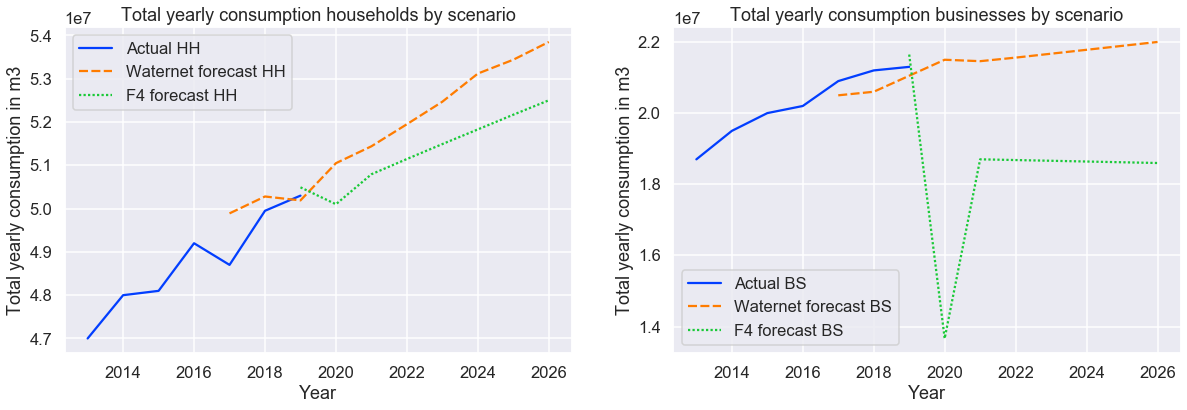

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(data=df_predicted[['Actual HH', 'Waternet forecast HH', 'F4 forecast HH']], ax=ax[0], palette='bright')
ax[0].set(xlabel='Year', ylabel='Total yearly consumption in m3',\
    title='Total yearly consumption households by scenario')

sns.lineplot(data=df_predicted[['Actual BS', 'Waternet forecast BS', 'F4 forecast BS']], ax=ax[1], palette='bright')
ax[1].set(xlabel='Year', ylabel='Total yearly consumption in m3',\
    title='Total yearly consumption businesses by scenario')

# Put a legend to the right side
#plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.5), ncol=1)

plt.show()

In [67]:
# Adding different scenario's:
scen_1 = pd.read_csv('data/scenario_1.csv')
scen_1 = scen_1.loc[scen_1.YEAR >= 2019].set_index(['REGION', 'YEAR'])
# normalize column values
scen_1[scen_1.columns] = fcst_scaler.transform(scen_1)
print(scen_1.shape)
scen_1

(52, 29)


862           0.696220   
             2022       5.053273                1.083862           0.689423   
Diemen       2019      -0.632714               -0.629518          -0.762532   
             2020      -0.628171               -0.634707          -0.762668   
             2021      -0.632697               -0.634707          -0.762668   
             2022      -0.631628               -0.634707          -0.762668   
Heemstede    2019      -0.641969               -0.639235          -0.557724   
             2020      -0.641969               -0.639235          -0.558883   
             2021      -0.641969               -0.639235          -0.559088   
             2022      -0.641969               -0.639235          -0.559292   
Muiden       2019      -0.641969               -0.639235          -0.756167   
             2020      -0.641969               -0.639235          -0.780035   
             2021      -0.641969               -0.639235          -0.780035   
             2022      -0.641969               -0.639235          -0.780035   
Nieuw-West   2019       0.063163                0.101165          -0.767987   
             2020       0.095004               -0.397367          -0.768669   
             2021       0.131374               -0.397367          -0.769397   
             2022       0.166429               -0.397367          -0.770124   
Noord        2019      -0.379608               -0.363752          -0.259490   
             2020      -0.361103               -0.547057          -0.259104   
             2021      -0.346023               -0.547057          -0.258763   
             2022      -0.328497               -0.547057          -0.258422   
Oost         2019      -0.037580               -0.004617           0.593611   
             2020      -0.041851               -0.442282           0.577450   
             2021      -0.020092               -0.442282           0.566834   
             2022      -0.012984               -0.442282           0.556219   
Ouder-Amstel 2019      -0.641969               -0.639235          -0.750030   
             2020      -0.641969               -0.639235          -0.750825   
             2021      -0.641969               -0.639235          -0.751121   
             2022      -0.641969               -0.639235          -0.751416   
West         2019       0.714453                0.785030           1.792909   
             2020       0.859285               -0.146536           1.790432   
             2021       0.923993               -0.146536           1.792864   
             2022       1.037308               -0.146536           1.795296   
Westpoort    2019      -0.373584               -0.357427          -0.779807   
             2020      -0.368408               -0.549455          -0.780035   
             2021      -0.641969               -0.549455          -0.780035   
             2022      -0.641969               -0.549455          -0.780035   
Zuid         2019       0.909842                0.990191           2.069548   
             2020       0.894528               -0.134970           2.072662   
             2021       0.954628               -0.134970           2.073776   
             2022       0.971639               -0.134970           2.074890   
Zuidoost     2019       0.007175                0.042376          -0.756622   
             2020       0.181335               -0.369034          -0.766555   
             2021       0.145746               -0.369034          -0.774716   
             2022       0.227852               -0.369034          -0.782876   

                   BUILT_1945_to_1965  BUILT_1965_to_1975  BUILT_1975_to_1985  \
REGION       YEAR                                                               
Amstelveen   2019            0.525884            1.441230           -0.154047   
             2020            0.522971            1.155977           -0.154258   
             2021            0.520944            0.988415           -0.154470   
             

In [68]:
# Joining test set with consumption per object type
scen_1_HB = scen_1.reset_index().merge(df_target_HB, how='left', on=['YEAR', 'REGION']).set_index(['REGION', 'YEAR'])
scen_1_ZB = scen_1.reset_index().merge(df_target_ZB, how='left', on=['YEAR', 'REGION']).set_index(['REGION', 'YEAR'])
# Adding group-meaned and de-meaned variables for TV vars for households
for var in tv_vars_hb:
    scen_1_HB = scen_1_HB.reset_index().merge(fcst_HB[var].mean(level=0).rename('{}_between'.format(var)),\
        on='REGION', how='left').set_index(['REGION', 'YEAR'])
    scen_1_HB['{}_within'.format(var)] = scen_1_HB[var] - scen_1_HB['{}_between'.format(var)]

    scen_1_ZB = scen_1_ZB.reset_index().merge(fcst_ZB[var].mean(level=0).rename('{}_between'.format(var)),\
        on='REGION', how='left').set_index(['REGION', 'YEAR'])
    scen_1_ZB['{}_within'.format(var)] = scen_1_ZB[var] - scen_1_ZB['{}_between'.format(var)]

scen_1_HB.head()

POPULATION  POPULATION 0 TO 15 Y/O  POPULATION 15 TO 25 Y/O  \
REGION     YEAR                                                                
Amstelveen 2019    0.199042                0.394736                 0.046964   
           2020    0.215560                0.414571                 0.069995   
           2021    0.253798                0.490099                 0.097827   
           2022    0.276527                0.527860                 0.115452   
Centrum    2019    0.119455               -0.620972                -0.056227   

                 POPULATION 25 TO 45 Y/O  POPULATION 45 TO 65 Y/O  \
REGION     YEAR                                                     
Amstelveen 2019                -0.167095                 0.257131   
           2020                -0.151735                 0.256874   
           2021                -0.138468                 0.292337   
           2022                -0.122587                 0.303545   
Centrum    2019                 0.282285                 0.291332   

                 POPULATION 65 Y/O AND UP  TOTAL HOUSEHOLDS  \
REGION     YEAR                                               
Amstelveen 2019                  1.117999          0.003661   
           2020                  1.152828          0.009225   
           2021                  1.225918          0.044906   
           2022                  1.270370          0.061129   
Centrum    2019                  0.424484          0.440044   

                 SINGLE-PERSON HOUSEHOLDS  HOUSEHOLDS W/O CHILDREN  \
REGION     YEAR                                                      
Amstelveen 2019                 -0.253064                 0.195936   
           2020                 -0.257113                 0.178774   
           2021                 -0.225771                 0.199117   
           2022                 -0.215832                 0.203642   
Centrum    2019                  0.744332                 0.550339   

                 HOUSEHOLDS /W CHILDREN  AIRBNB_REVIEWS  UNEMPLOYMENT_WW  \
REGION     YEAR                                                            
Amstelveen 2019                0.466691       -0.499058        -0.614530   
           2020                0.513946       -0.499058        -0.673566   
           2021                0.566803       -0.499058        -0.673566   
           2022                0.605390       -0.499058        -0.673566   
Centrum    2019               -0.489502        5.213496        -0.229513   

                 NUMBER_OF_JOBS  GUESTS_HOTELS  OVERNIGHT_STAYS_HOTELS  \
REGION     YEAR                                                          
Amstelveen 2019       -0.098441      -0.600677               -0.595878   
           2020       -0.061289      -0.600903               -0.625757   
           2021       -0.061289      -0.598703               -0.625757   
           2022       -0.061289      -0.598062               -0.625757   
Centrum    2019        1.784846       4.280986                4.529946   

                 BUILT_before_1945  BUILT_1945_to_1965  BUILT_1965_to_1975  \
REGION     YEAR                                                              
Amstelveen 2019          -0.620689            0.525884            1.441230   
           2020          -0.621053            0.522971            1.155977   
           2021          -0.621189            0.520944            0.988415   
           2022          -0.621326            0.518917            0.820853   
Centrum    2019           0.719088           -0.633171           -0.934383   

                 BUILT_1975_to_1985  BUILT_1985_to_1995  BUILT_1995_to_2005  \
REGION     YEAR                                                               
Amstelveen 2019           -0.154047            0.901377           -0.044253   
           2020           -0.154258            0.985056           -0.040774   
           2021           -0.154470            1.026981           -0.037610   
           2022           -0.154681          

In [69]:
# Forecasting on household data
exog_vars = ['{}_between'.format(var) for var in tv_vars_hb] + ['{}_within'.format(var) for var in tv_vars_hb]
exog = sm.add_constant(scen_1_HB[exog_vars])
res_scen_1_hb = RE_res_hb.predict(exog, effects=True)
pred_scen_1 = res_scen_1_hb.sum(level=1).rename(columns={'predictions': 'Scen 1 forecast HH'})
pred_scen_1

,Scen 1 forecast HH
YEAR,
2019,3.461481e+07
2020,3.471101e+07
2021,3.531941e+07
2022,3.587626e+07


In [70]:
df_predicted.join(pred_scen_1)

,Actual HH,Waternet forecast HH,F4 forecast HH,Actual BS,Waternet forecast BS,F4 forecast BS,Total consumption,F4 forecast total,Scen 1 forecast HH
YEAR,,,,,,,,,
2013,47000000.0,NaN,NaN,18700000.0,NaN,NaN,65700000.0,NaN,NaN
2014,48000000.0,NaN,NaN,19500000.0,NaN,NaN,67500000.0,NaN,NaN
2015,48100000.0,NaN,NaN,20000000.0,NaN,NaN,68100000.0,NaN,NaN
2016,49200000.0,NaN,NaN,20200000.0,NaN,NaN,69400000.0,NaN,NaN
2017,48700000.0,49890000.0,NaN,20900000.0,20500000.0,NaN,69600000.0,NaN,NaN
2018,49950000.0,50280000.0,NaN,21200000.0,20600000.0,NaN,71150000.0,NaN,NaN
2019,50300000.0,50190000.0,5.049165e+07,21300000.0,21050000.0,2.164637e+07,71600000.0,7.213803e+07,3.461481e+07
2020,NaN,51050000.0,5.010118e+07,NaN,21500000.0,1.366388e+07,NaN,6.376507e+07,3.471101e+07
2021,NaN,51440000.0,5.079362e+07,NaN,21460000.0,1.870072e+07,NaN,6.949434e+07,3.531941e+07
